# A Learning-based Model for Assessment of Covid-19 Severity

## Import library, define some useful function

In [1]:
# basic
import warnings
import pickle
import json
from functools import partial
import pandas as pd
import numpy as np
warnings.filterwarnings("ignore")

# classifiers
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# spliting
from sklearn.model_selection import train_test_split, StratifiedKFold

# metrics
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, f1_score, accuracy_score, recall_score, precision_score, confusion_matrix

# statistical tools
from scipy.stats import shapiro, mannwhitneyu, chi2_contingency

# visualization
from IPython.display import display, IFrame,Image
import shap
import tensorboardX
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
%matplotlib inline
sns.set(style="whitegrid", context="paper", font="sans-serif",
        rc={'figure.figsize': (5, 5), 'figure.dpi': 1200, "font.size": 12, "axes.titlesize": 11,
            "axes.labelsize": 10})

# fix random seed for reproducebility
SEED=8888

# it takes some time to run cross validation, turn off if you don't need it
RUN_CV_RESULT = True
CV_RESULT_REPEAT = 25

VAR_NUM = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

COMPARED_METHOD = [
    "XGBoost",
    "Logistic",
    "Random Forest",
    "SVM",
    "Decision Tree",
    "LDA"
]

# variables
VARS_ALL = \
    {
        "num": ['Interval', 'Age', 'Laboratory_test_WBC', 'Laboratory_test_L', 'Laboratory_test_N',
                'Laboratory_test_ESR_(mm/hr)', 'Laboratory_test_CRP_(mg/L)', 'Laboratory_test_PCT_(ng/ml)',
                'Laboratory_test_HTI_(pg/ml)',
                'Laboratory_test_D_dimer_(ug/ml)',
                'Laboratory_test_ALT_(U/L)', 'Laboratory_test_AST_(U/L)', 'Laboratory_test_TB_(umol/L)',
                'Laboratory_test_ALB_(g/L)', 'Laboratory_test_LDH_(U/L)', 'Laboratory_test_BUN_(mmol/L)',
                'Laboratory_test_SCr_(umol/L)', 'Laboratory_test_PT_(s)', 'Laboratory_test_Lac_(mmol/L)',
                'Laboratory_test_IL_6_(pg/ml)', 'Laboratory_test_Lymphopenia', 'CK', 'Troponin_I', 'O2%',
                'consolidation_ratio%', 'ground_glass_opacity_ratio%'],
        "cate": ['Sex_F', 'Underlying_comorbidities_Hypertension', 'Underlying_comorbidities_Endocrine_disease',
                 'Underlying_comorbidities_CVD', 'Underlying_comorbidities_Chronic_Lung_disease',
                 'Underlying_comorbidities_Digestive_Disease', 'Underlying_comorbidities_Renal_disease',
                 'Underlying_comorbidities_Tumor', 'Underlying_comorbidities_Cerebrovascular/Nervous_Disease',
                 'Underlying_comorbidities_Immune_disorder', 'Underlying_comorbidities_Others', 'Symptoms_Fever',
                 'Symptoms_Cough', 'Symptoms_Expectoration', 'Symptoms_Hemoptysis', 'Symptoms_Dyspnea',
                 'Symptoms_Catarrh', 'Symptoms_Fatigue', 'Symptoms_Anorexia', 'Symptoms_Nausea/Emesis',
                 'Symptoms_Myalgia', 'Symptoms_Dizziness/Headache', 'Symptoms_Pharyngalgia',
                 'Symptoms_Chest/back_pain', 'Symptoms_Chest_tightness', 'Symptoms_Abdominal_pain/diarrhea',
                 'any_Underlying', 'any_Symptoms']

    }

# compared METHODS
METHODS = [
    {
        "name": "XGBoost",
        "hyper_parameters": {'alpha': 4.0, 'colsample_bytree': 0.9, 'eta': 0.25, 'gamma': 1, 'lambda': 2,
                             'max_depth': 8, 'min_child_weight': 7.0, 'scale_pos_weight': 20.0,
                             'subsample': 0.9,
                             'n_estimators': 120,"random_state":SEED},
        "classifier": XGBClassifier
    },
    {
        "name": "FeatureImportance",
        "hyper_parameters": {'max_depth': 4, 'learning_rate': 0.2, 'reg_lambda': 1, 'n_estimators': 150,
                             'subsample': 0.9, "colsample_bytree": 0.9},
        "classifier": XGBClassifier
    },
    {
        "name": "Logistic",
        "hyper_parameters": {
            "penalty": 'l2'},
        "classifier": LogisticRegression
    },
    {
        "name": "Random Forest",
        "hyper_parameters": {"criterion": "entropy"},
        "classifier": RandomForestClassifier
    },
    {
        "name": "SVM",
        "hyper_parameters": {"kernel": "rbf"},
        "classifier": SVC
    },
    {
        "name": "Decision Tree",
        "hyper_parameters": {'max_depth': 3, 'n_estimators': 1},
        "classifier": XGBClassifier
    },
    {
        "name": "LDA",
        "hyper_parameters": {},
        "classifier": LinearDiscriminantAnalysis
    },

]

# utility functions
sensitivity=lambda y_true, y_pred:classification_report(y_true, y_pred, output_dict=True, target_names=["Non_Server", "Server"])["Server"]["recall"]
specifity=lambda y_true, y_pred:classification_report(y_true, y_pred, output_dict=True, target_names=["Non_Server", "Server"])["Non_Server"]["recall"]
TN=lambda y_true, y_pred:confusion_matrix(y_true, y_pred).ravel()[0]
FP=lambda y_true, y_pred:confusion_matrix(y_true, y_pred).ravel()[1]
FN=lambda y_true, y_pred:confusion_matrix(y_true, y_pred).ravel()[2]
TP=lambda y_true, y_pred:confusion_matrix(y_true, y_pred).ravel()[3]
def q25(x):
    return np.quantile(x, q=0.25)
def q75(x):
    return np.quantile(x, q=0.75)


# compared metrics
MY_METRICS = {
    # commented metrics not used because of limited space and selected metrics are sufficient to estimate the performance

    # "F1_binary": partial(f1_score, average="binary"),
    # "F1_macro": partial(f1_score, average="macro"),
    "F1_weighted": partial(f1_score, average="weighted"),
    # "Precision_binary": partial(precision_score, average="binary"),
    # "Precision_macro": partial(precision_score, average="macro"),
    # "Precision_weighted": partial(precision_score, average="weighted"),
    # "Recall_binary": partial(recall_score, average="binary"),
    # "Recall_macro": partial(recall_score, average="macro"),
    # "Recall_weighted": partial(recall_score, average="weighted"),
    "Accuracy": accuracy_score,
    "Sensitivity": sensitivity,
    "Specifity": specifity,
    "tn": TN,
    "fp": FP,
    "fn": FN,
    "tp": TP,
}

# METHODS of which AUC can be calculated
HAVE_AUC_METHOD = [
    "XGBoost",
    "Logistic",
    "Random Forest",
    "Decision Tree",
    "LDA"]

# use short name for display in figure
FEATURE_NAME_MAPPING = {
    "Laboratory_test_CRP_(mg/L)": "CRP",
    "Laboratory_test_L": "L",
    "Laboratory_test_ALB_(g/L)": "ALB",
    "Laboratory_test_LDH_(U/L)": "LDH",
    "Age": "Age",
    "Laboratory_test_AST_(U/L)": "AST",
    "Laboratory_test_N": "N",
    "CK": "CK",
    "Laboratory_test_ALT_(U/L)": "ALT",
    "Laboratory_test_D_dimer_(ug/ml)": "D dimer",
    "Symptoms_Fever": "Fever",
    "Symptoms_Dyspnea": "Dyspnea",
}

## Loading data

In [2]:
# load dataset
dataset = pd.read_csv("./dataset.csv", index_col=0)
dataset_non_tranmit = dataset[dataset.non_severe_to_severe != 1]
y = "Degree_Severe"
ALL_X = [*VARS_ALL["num"], *VARS_ALL["cate"]]

# make table_1 to show statistics
table_1=pd.DataFrame()
for var in VARS_ALL["num"]:
    t={}
    t["var"]=var
    t["support"]=len(dataset[var].dropna())
    t["mean"]=dataset[var].dropna().mean()
    t["std"]=dataset[var].dropna().std()
    table_1=table_1.append(t,ignore_index=True)

for var in VARS_ALL["cate"]:
    t={}
    t["var"]=var
    t["support"]=len(dataset[[var,y]].dropna())
    t["pos"]=len(dataset[[var,y]].dropna()[dataset[[var,y]].dropna()[var]==1])
    t["pos_ratio"]=t["pos"]/len(dataset[[var,y]])
    table_1=table_1.append(t,ignore_index=True)
display(table_1)
table_1.to_csv("./paper/Table_1.csv")

mean         std  support  \
0     5.887526   17.359200    489.0   
1    47.632721   15.623882    599.0   
2     6.020119   15.977523    506.0   
3     1.251465    1.219291    499.0   
4     3.637395    2.734587    499.0   
5    43.748400   28.857578    275.0   
6    25.239705   28.924595    454.0   
7     0.914247    7.580369    186.0   
8    11.947500    0.871979     12.0   
9    68.261885  515.415607    390.0   
10   25.537870   15.469870    399.0   
11   29.499457   16.150990    405.0   
12   13.559605    8.086948    380.0   
13   39.745315    9.281605    444.0   
14  229.496527  118.406910    429.0   
15    5.288182    3.344382     22.0   
16   62.515640   34.388566    445.0   
17   13.274167    3.335682    156.0   
18  271.372910  359.027483    134.0   
19   18.890000         NaN      1.0   
20    0.607143    0.492805     56.0   
21  110.225677  118.376722    384.0   
22    7.059484   12.812297     31.0   
23   93.929892   14.691506    186.0   
24    4.896145    7.468067     55.0   
25    1.160691    3.380721     55.0   
26         NaN         NaN    599.0   
27         NaN         NaN    478.0   
28         NaN         NaN    478.0   
29         NaN         NaN    477.0   
30         NaN         NaN    477.0   
31         NaN         NaN    477.0   
32         NaN         NaN    477.0   
33         NaN         NaN    477.0   
34         NaN         NaN    477.0   
35         NaN         NaN    477.0   
36         NaN         NaN    477.0   
37         NaN         NaN    578.0   
38         NaN         NaN    479.0   
39         NaN         NaN    103.0   
40         NaN         NaN    103.0   
41         NaN         NaN    545.0   
42         NaN         NaN    104.0   
43         NaN         NaN    479.0   
44         NaN         NaN    105.0   
45         NaN         NaN    481.0   
46         NaN         NaN    481.0   
47         NaN         NaN    481.0   
48         NaN         NaN    105.0   
49         NaN         NaN    105.0   
50         NaN         NaN    151.0   
51         NaN         NaN    105.0   
52         NaN         NaN    601.0   
53         NaN         NaN    601.0   

                                                  var    pos  pos_ratio  
0                                            Interval    NaN        NaN  
1                                                 Age    NaN        NaN  
2                                 Laboratory_test_WBC    NaN        NaN  
3                                   Laboratory_test_L    NaN        NaN  
4                                   Laboratory_test_N    NaN        NaN  
5                         Laboratory_test_ESR_(mm/hr)    NaN        NaN  
6                          Laboratory_test_CRP_(mg/L)    NaN        NaN  
7                         Laboratory_test_PCT_(ng/ml)    NaN        NaN  
8                         Laboratory_test_HTI_(pg/ml)    NaN        NaN  
9                     Laboratory_test_D_dimer_(ug/ml)    NaN        NaN  
10                          Laboratory_test_ALT_(U/L)    NaN        NaN  
11                          Laboratory_test_AST_(U/L)    NaN        NaN  
12                        Laboratory_test_TB_(umol/L)    NaN        NaN  
13                          Laboratory_test_ALB_(g/L)    NaN        NaN  
14                          Laboratory_test_LDH_(U/L)    NaN        NaN  
15                       Laboratory_test_BUN_(mmol/L)    NaN        NaN  
16                       Laboratory_test_SCr_(umol/L)    NaN        NaN  
17                             Laboratory_test_PT_(s)    NaN        NaN  
18                       Laboratory_test_Lac_(mmol/L)    NaN        NaN  
19                       Laboratory_test_IL_6_(pg/ml)    NaN        NaN  
20                        Laboratory_test_Lymphopenia    NaN        NaN  
21                                                 CK    NaN        NaN  
22                                         Troponin_I    NaN        NaN  
23                                                O2%    NaN        NaN  
24            

## Missing value

Number of Observations  Number of Variables  Thresh alpha
0                       0.0                 55.0           0.0
1                       0.0                 55.0           1.0
2                       0.0                 54.0           2.0
3                       0.0                 54.0           3.0
4                       0.0                 54.0           4.0
..                      ...                  ...           ...
595                   554.0                  0.0         595.0
596                   554.0                  0.0         596.0
597                   554.0                  0.0         597.0
598                   554.0                  0.0         598.0
599                   554.0                  0.0         599.0

[600 rows x 3 columns]

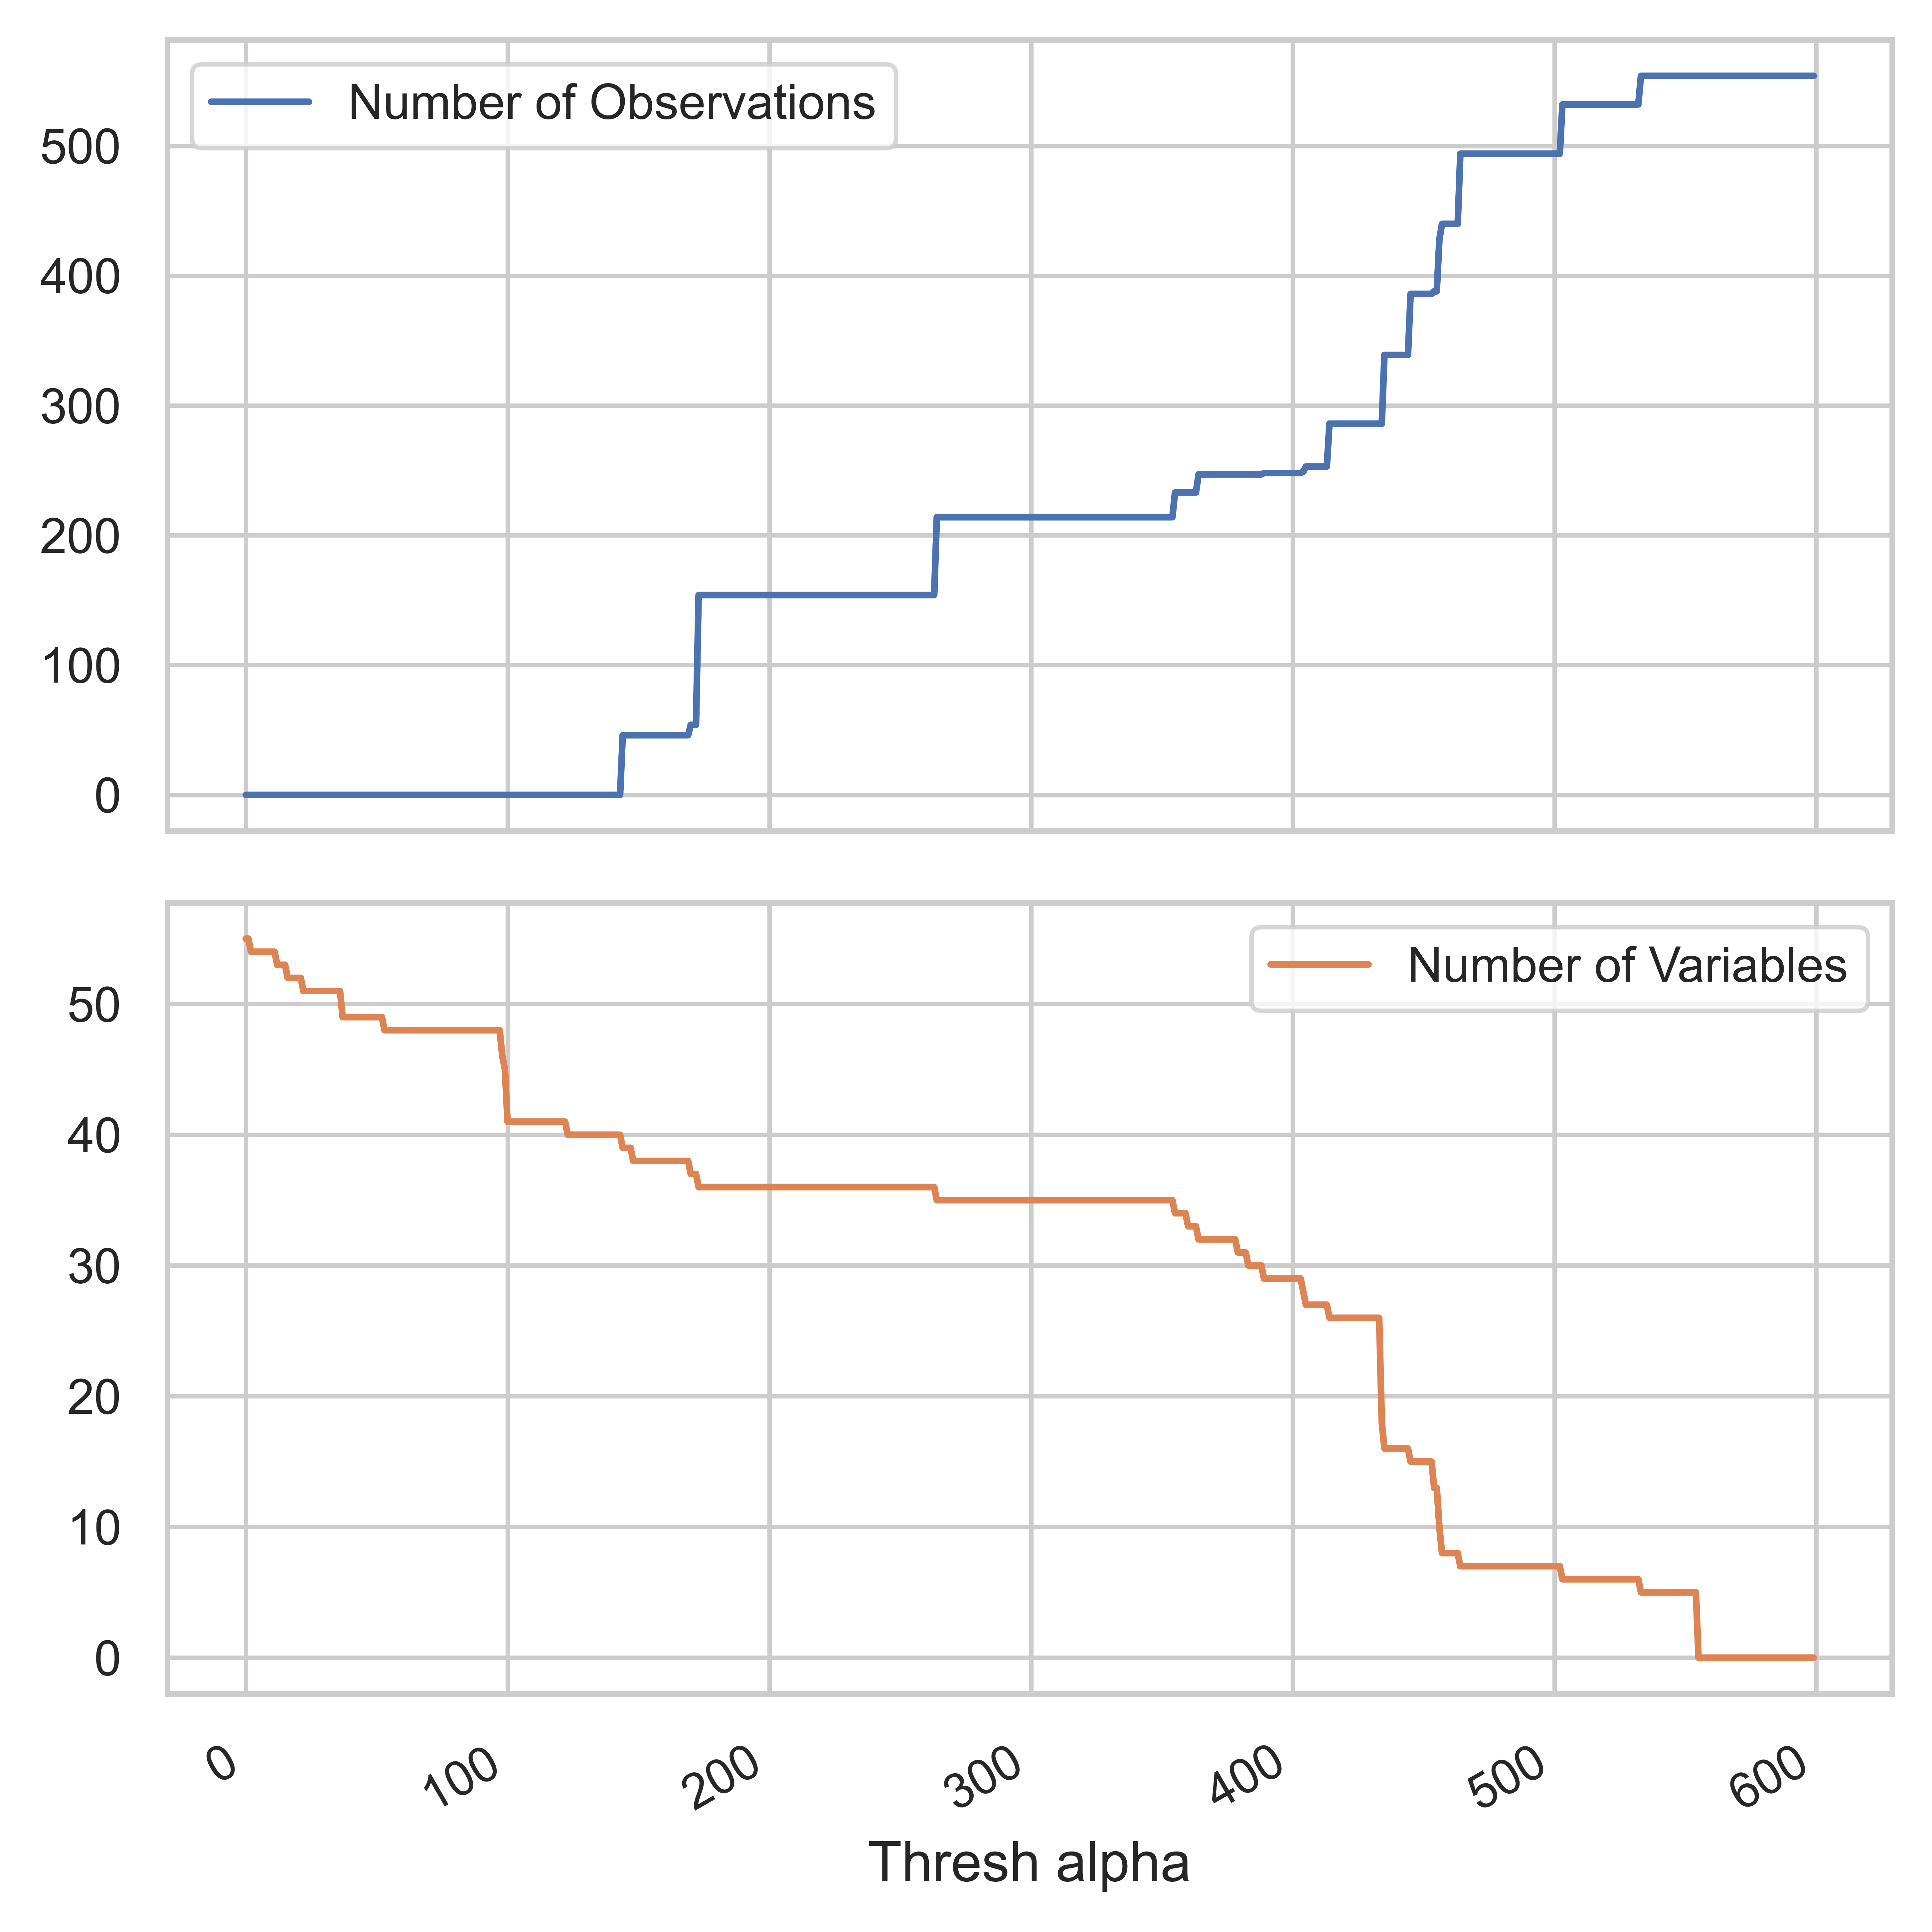

In [3]:
# show the relationship between included variables and available observations
obs_vars_alpha = pd.DataFrame()
for i in range(600):
    t = dataset_non_tranmit[[*ALL_X, y]].dropna(axis="columns", thresh=i).dropna()
    obs_vars_alpha = obs_vars_alpha.append(
        {
            "Thresh alpha": i,
            "Number of Observations": len(t),
            "Number of Variables": len(t.columns)
        }, ignore_index=True)
display(obs_vars_alpha)
obs_vars_alpha.plot(x="Thresh alpha", y=["Number of Observations", "Number of Variables"], subplots=True)
plt.tight_layout()
# plt.show()
plt.savefig("./paper/Supplementary_Figure_2.png")
# Image(filename="./paper/Supplementary_Figure_2.png")
# plt.clf()
# plt.close()

In [4]:
# remove missing value
THRESHOLD_ALPHA=350 # the THRESHOLD_ALPHA is determined from above figure
VARS_REMOVED_MISSING={}
t = dataset_non_tranmit[[*ALL_X, y]].dropna(axis="columns", thresh=THRESHOLD_ALPHA).dropna()
t = t.loc[:, (t != 0).any(axis=0)].loc[:, (t != False).any(axis=0)].loc[:, (t != True).any(axis=0)]
dataset_non_tranmit_removing_missing_value=t
display(dataset_non_tranmit_removing_missing_value)
dataset_non_tranmit_removing_missing_value.to_csv("./tmp/dataset_remove_missing_value_thresh_{}.csv".format(THRESHOLD_ALPHA))

VARS_REMOVED_MISSING["num"] = []
VARS_REMOVED_MISSING["cate"] = []
for i in VARS_ALL["num"]:
    if i in dataset_non_tranmit_removing_missing_value.columns:
        VARS_REMOVED_MISSING["num"].append(i)
for i in VARS_ALL["cate"]:
    if i in dataset_non_tranmit_removing_missing_value.columns:
        VARS_REMOVED_MISSING["cate"].append(i)

Interval   Age  Laboratory_test_WBC  Laboratory_test_L  \
908        9.0  30.0                 3.32               0.91   
909       27.0  54.0                 2.58               0.34   
910        6.0  29.0                 6.79               2.25   
912        8.0  84.0                19.64               0.37   
913       31.0  43.0                 3.02               0.68   
...        ...   ...                  ...                ...   
1244      11.0  29.0                 3.27               0.55   
1245       8.0  45.0                 3.26               1.00   
1246       1.0  67.0                 4.15               1.13   
1248       5.0  41.0                 5.66               1.75   
1249       2.0  51.0                 4.89               1.60   

      Laboratory_test_N  Laboratory_test_CRP_(mg/L)  \
908                1.77                       0.785   
909                1.94                      16.300   
910                4.10                       4.750   
912               18.59                       6.530   
913                2.08                      32.700   
...                 ...                         ...   
1244               2.37                      62.360   
1245               1.99                      31.850   
1246               2.61                       0.200   
1248               3.49                      21.230   
1249               2.75                      12.920   

      Laboratory_test_D_dimer_(ug/ml)  Laboratory_test_ALT_(U/L)  \
908                              1.12                      16.80   
909                              0.27                      19.00   
910                              0.37                      25.10   
912                              0.63                      21.00   
913                              0.16                      15.30   
...                               ...                        ...   
1244                             0.05                      11.91   
1245                             0.12                      58.42   
1246                             0.80                      19.70   
1248                             0.26                      12.89   
1249                             0.15                      15.90   

      Laboratory_test_AST_(U/L)  Laboratory_test_TB_(umol/L)  ...  \
908                       28.20                         4.94  ...   
909                       26.90                        11.03  ...   
910                       23.40                        24.80  ...   
912                       38.00                         9.89  ...   
913                       24.50                        14.82  ...   
...                         ...                          ...  ...   
1244                      17.55                        16.35  ...   
1245                      22.22                         8.02  ...   
1246                      24.60                        10.10  ...   
1248                      21.33                         4.62  ...   
1249                      25.05                         5.54  ...   

      Symptoms_Fever  Symptoms_Cough  Symptoms_Dyspnea  Symptoms_Fatigue  \
908              1.0             1.0               0.0               0.0   
909              1.0             0.0               1.0               1.0   
910              1.0             1.0               0.0               0.0   
912              1.0             1.0               0.0               1.0   
913              1.0             1.0               0.0               0.0   
...              ...             ...               ...               ...   
1244             1.0             0.0               0.0               0.0   
1245             0.0             1.0               0.0               0.0   
1246             0.0             0.0               0.0               1.0   
1248             1.0             1.0               0.0               0.0   
1249             1.0             1.0               0.0               0.0   

      Symptoms_Na

## Univariant Statistical Test

In [5]:
# normalty test
normalty_test_result=pd.DataFrame()
for var in dataset_non_tranmit_removing_missing_value.columns:
    if var in VARS_REMOVED_MISSING["num"]:
        p_value = shapiro(dataset_non_tranmit_removing_missing_value[[var, y]].dropna().astype(float))[1]
        normalty_test_result=normalty_test_result.append(
            {
                "var":var,
                "pvalue":p_value,
                "is_normal":p_value<0.05,
                "num_not_nan":len(dataset_non_tranmit_removing_missing_value[[var, y]].dropna().astype(float))
            },ignore_index=True)
display(normalty_test_result)
if len(normalty_test_result)==len(normalty_test_result[normalty_test_result.is_normal==True]):
    print("all_normal")

is_normal  num_not_nan        pvalue                              var
0         1.0        214.0  5.008969e-40                         Interval
1         1.0        214.0  7.322816e-22                              Age
2         1.0        214.0  9.493517e-41              Laboratory_test_WBC
3         1.0        214.0  2.404522e-19                Laboratory_test_L
4         1.0        214.0  2.933766e-25                Laboratory_test_N
5         1.0        214.0  1.694774e-31       Laboratory_test_CRP_(mg/L)
6         1.0        214.0  1.759260e-40  Laboratory_test_D_dimer_(ug/ml)
7         1.0        214.0  8.080286e-25        Laboratory_test_ALT_(U/L)
8         1.0        214.0  7.861322e-26        Laboratory_test_AST_(U/L)
9         1.0        214.0  8.385925e-23      Laboratory_test_TB_(umol/L)
10        1.0        214.0  2.150373e-25        Laboratory_test_ALB_(g/L)
11        1.0        214.0  6.154584e-22        Laboratory_test_LDH_(U/L)
12        1.0        214.0  7.560675e-23     Laboratory_test_SCr_(umol/L)
13        1.0        214.0  3.341286e-32                               CK

all_normal


In [6]:
# mannwhitneyu-test
uni_test_result = pd.DataFrame()
for var in VARS_REMOVED_MISSING["num"]:
    t = dataset_non_tranmit_removing_missing_value[[var, y]].dropna()
    severe = t[t.Degree_Severe == 1][var]
    non_severe = t[t.Degree_Severe == 0][var]
    uni_test_result = uni_test_result.append(
        {"var": var,
         "pvalue": mannwhitneyu(severe, non_severe)[1],
         "severe_mean": severe.mean(),
         "severe_std": severe.std(),
         "nonsevere_mean": non_severe.mean(),
         "nonsevere_std": non_severe.std(),
         "severe_count": len(severe),
         "nonsevere_count": len(non_severe)
         }
        , ignore_index=True
    )

In [7]:
# chi2test
for var in VARS_REMOVED_MISSING["cate"]:
    ct = pd.crosstab(dataset_non_tranmit_removing_missing_value[y], dataset_non_tranmit_removing_missing_value[var], margins=True, dropna=True)
    uni_test_result = uni_test_result.append(
        {"var": var,
         "pvalue": chi2_contingency(ct)[1],
         "severe_mean": 0,
         "severe_std": -1, # indicate it's category variable
         "nonsevere_mean": 0,
         "nonsevere_std": 0,
         "severe_count": ct.iloc[1, 2] if len(ct.columns) > 1 else 0,
         "nonsevere_count": ct.iloc[0, 2]
         }
        , ignore_index=True
    )
display(uni_test_result)
uni_test_result.to_csv("./paper/Supplementary_Table_1.csv")
significant_vars=uni_test_result[uni_test_result.pvalue<=0.05].sort_values(axis=0, ascending=True, by='pvalue')
display(significant_vars["var"].tolist())

nonsevere_count  nonsevere_mean  nonsevere_std        pvalue  \
0             171.0        4.684211      28.663458  1.644870e-01   
1             171.0       44.058480      14.807275  2.575836e-07   
2             171.0        7.047251      27.153884  9.958830e-02   
3             171.0        1.306199       0.601988  1.224041e-10   
4             171.0        3.211228       1.797459  4.501490e-04   
5             171.0       16.465684      20.364019  4.869933e-10   
6             171.0       20.235158      98.019697  1.229363e-03   
7             171.0       23.838129      16.036746  2.707035e-03   
8             171.0       27.262047      16.972126  6.954676e-08   
9             171.0       13.046491       7.223591  1.609718e-01   
10            171.0       39.609006       4.232346  3.352471e-10   
11            171.0      191.276608      78.160000  8.219554e-10   
12            171.0       56.734561      19.673839  3.951699e-01   
13            171.0       97.369064     112.444299  8.869487e-04   
14            171.0        0.000000       0.000000  7.078687e-01   
15            171.0        0.000000       0.000000  9.939700e-01   
16            171.0        0.000000       0.000000  9.977970e-01   
17            171.0        0.000000       0.000000  9.545012e-01   
18            171.0        0.000000       0.000000  3.912663e-01   
19            171.0        0.000000       0.000000  3.256702e-01   
20            171.0        0.000000       0.000000  1.000000e+00   
21            171.0        0.000000       0.000000  9.995425e-01   
22            171.0        0.000000       0.000000  8.144810e-01   
23            171.0        0.000000       0.000000  3.131509e-03   
24            171.0        0.000000       0.000000  7.187189e-02   
25            171.0        0.000000       0.000000  8.016032e-05   
26            171.0        0.000000       0.000000  7.303135e-02   
27            171.0        0.000000       0.000000  8.635115e-01   
28            171.0        0.000000       0.000000  9.994211e-01   
29            171.0        0.000000       0.000000  9.555000e-01   
30            171.0        0.000000       0.000000  4.739774e-01   
31            171.0        0.000000       0.000000  3.608895e-01   

    severe_count  severe_mean  severe_std  \
0           43.0     7.046512    3.909412   
1           43.0    57.534884   13.925565   
2           43.0     5.931628    3.901081   
3           43.0     0.733953    0.328808   
4           43.0     4.832326    3.831604   
5           43.0    51.962326   42.511674   
6           43.0     1.167302    2.525703   
7           43.0    30.170000   16.712771   
8           43.0    38.398837   16.174991   
9           43.0    13.969302    6.865567   
10          43.0    34.177209    4.943480   
11          43.0   291.986047  100.753883   
12          43.0    60.912326   34.658565   
13          43.0   151.823256  149.724905   
14          43.0     0.000000   -1.000000   
15          43.0     0.000000   -1.000000   
16          43.0     0.000000   -1.000000   
17          43.0     0.000000   -1.000000   
18          43.0     0.000000   -1.000000   
19          43.0     0.000000   -1.000000   
20          43.0     0.000000   -1.000000   
21          43.0     0.000000   -1.000000   
22          43.0     0.000000   -1.000000   
23          43.0     0.000000   -1.000000   
24          43.0     0.000000   -1.000000   
25          43.0     0.000000   -1.000000   
26          43.0     0.000000   -1.000000   
27          43.0     0.000000   -1.000000   
28          43.0     0.000000   -1.000000   
29          43.0     0.000000   -1.000000   
30          43.0     0.000000   -1.000000   
31          43.0     0.000000   -1.000000   

                                                  var  
0                                            Interval  
1                                                 Age  
2                                 Laboratory_test_WBC  
3                                   Laboratory_te

['Laboratory_test_L',
 'Laboratory_test_ALB_(g/L)',
 'Laboratory_test_CRP_(mg/L)',
 'Laboratory_test_LDH_(U/L)',
 'Laboratory_test_AST_(U/L)',
 'Age',
 'Symptoms_Dyspnea',
 'Laboratory_test_N',
 'CK',
 'Laboratory_test_D_dimer_(ug/ml)',
 'Laboratory_test_ALT_(U/L)',
 'Symptoms_Fever']

## Benchmark

In [8]:
# set
VARS_REMOVED_MISSING_SIGNIFICANT={
    'num': ["Laboratory_test_CRP_(mg/L)", "Laboratory_test_L", "Laboratory_test_ALB_(g/L)", "Laboratory_test_LDH_(U/L)",
            "Age", "Laboratory_test_AST_(U/L)", "Laboratory_test_N", "CK",
            "Laboratory_test_ALT_(U/L)", "Laboratory_test_D_dimer_(ug/ml)"],
    'cate': ["Symptoms_Fever", "Symptoms_Dyspnea"]}

# normalization
for i in VARS_REMOVED_MISSING_SIGNIFICANT["num"]:
    dataset_non_tranmit_removing_missing_value[i] = (dataset_non_tranmit_removing_missing_value[i] - dataset_non_tranmit_removing_missing_value[i].mean()) / dataset_non_tranmit_removing_missing_value[i].std()

SIGNIFICANT_X = [*VARS_REMOVED_MISSING_SIGNIFICANT["num"], *VARS_REMOVED_MISSING_SIGNIFICANT["cate"]]
X_train, X_test, y_train, y_test = train_test_split(dataset_non_tranmit_removing_missing_value[SIGNIFICANT_X], dataset_non_tranmit_removing_missing_value[[y]], test_size=0.3, stratify=dataset_non_tranmit_removing_missing_value[[y]],
                                                    random_state=SEED)

### Feature importance

Variables_name Variables  Importance
1                 Laboratory_test_L         L    0.977721
3         Laboratory_test_LDH_(U/L)       LDH    0.903002
0        Laboratory_test_CRP_(mg/L)       CRP    0.850362
6                 Laboratory_test_N         N    0.583498
4                               Age       Age    0.564310
8         Laboratory_test_ALT_(U/L)       ALT    0.482055
9   Laboratory_test_D_dimer_(ug/ml)   D dimer    0.478631
2         Laboratory_test_ALB_(g/L)       ALB    0.437452
5         Laboratory_test_AST_(U/L)       AST    0.321763
7                                CK        CK    0.309950
11                 Symptoms_Dyspnea   Dyspnea    0.040308
10                   Symptoms_Fever     Fever    0.002511

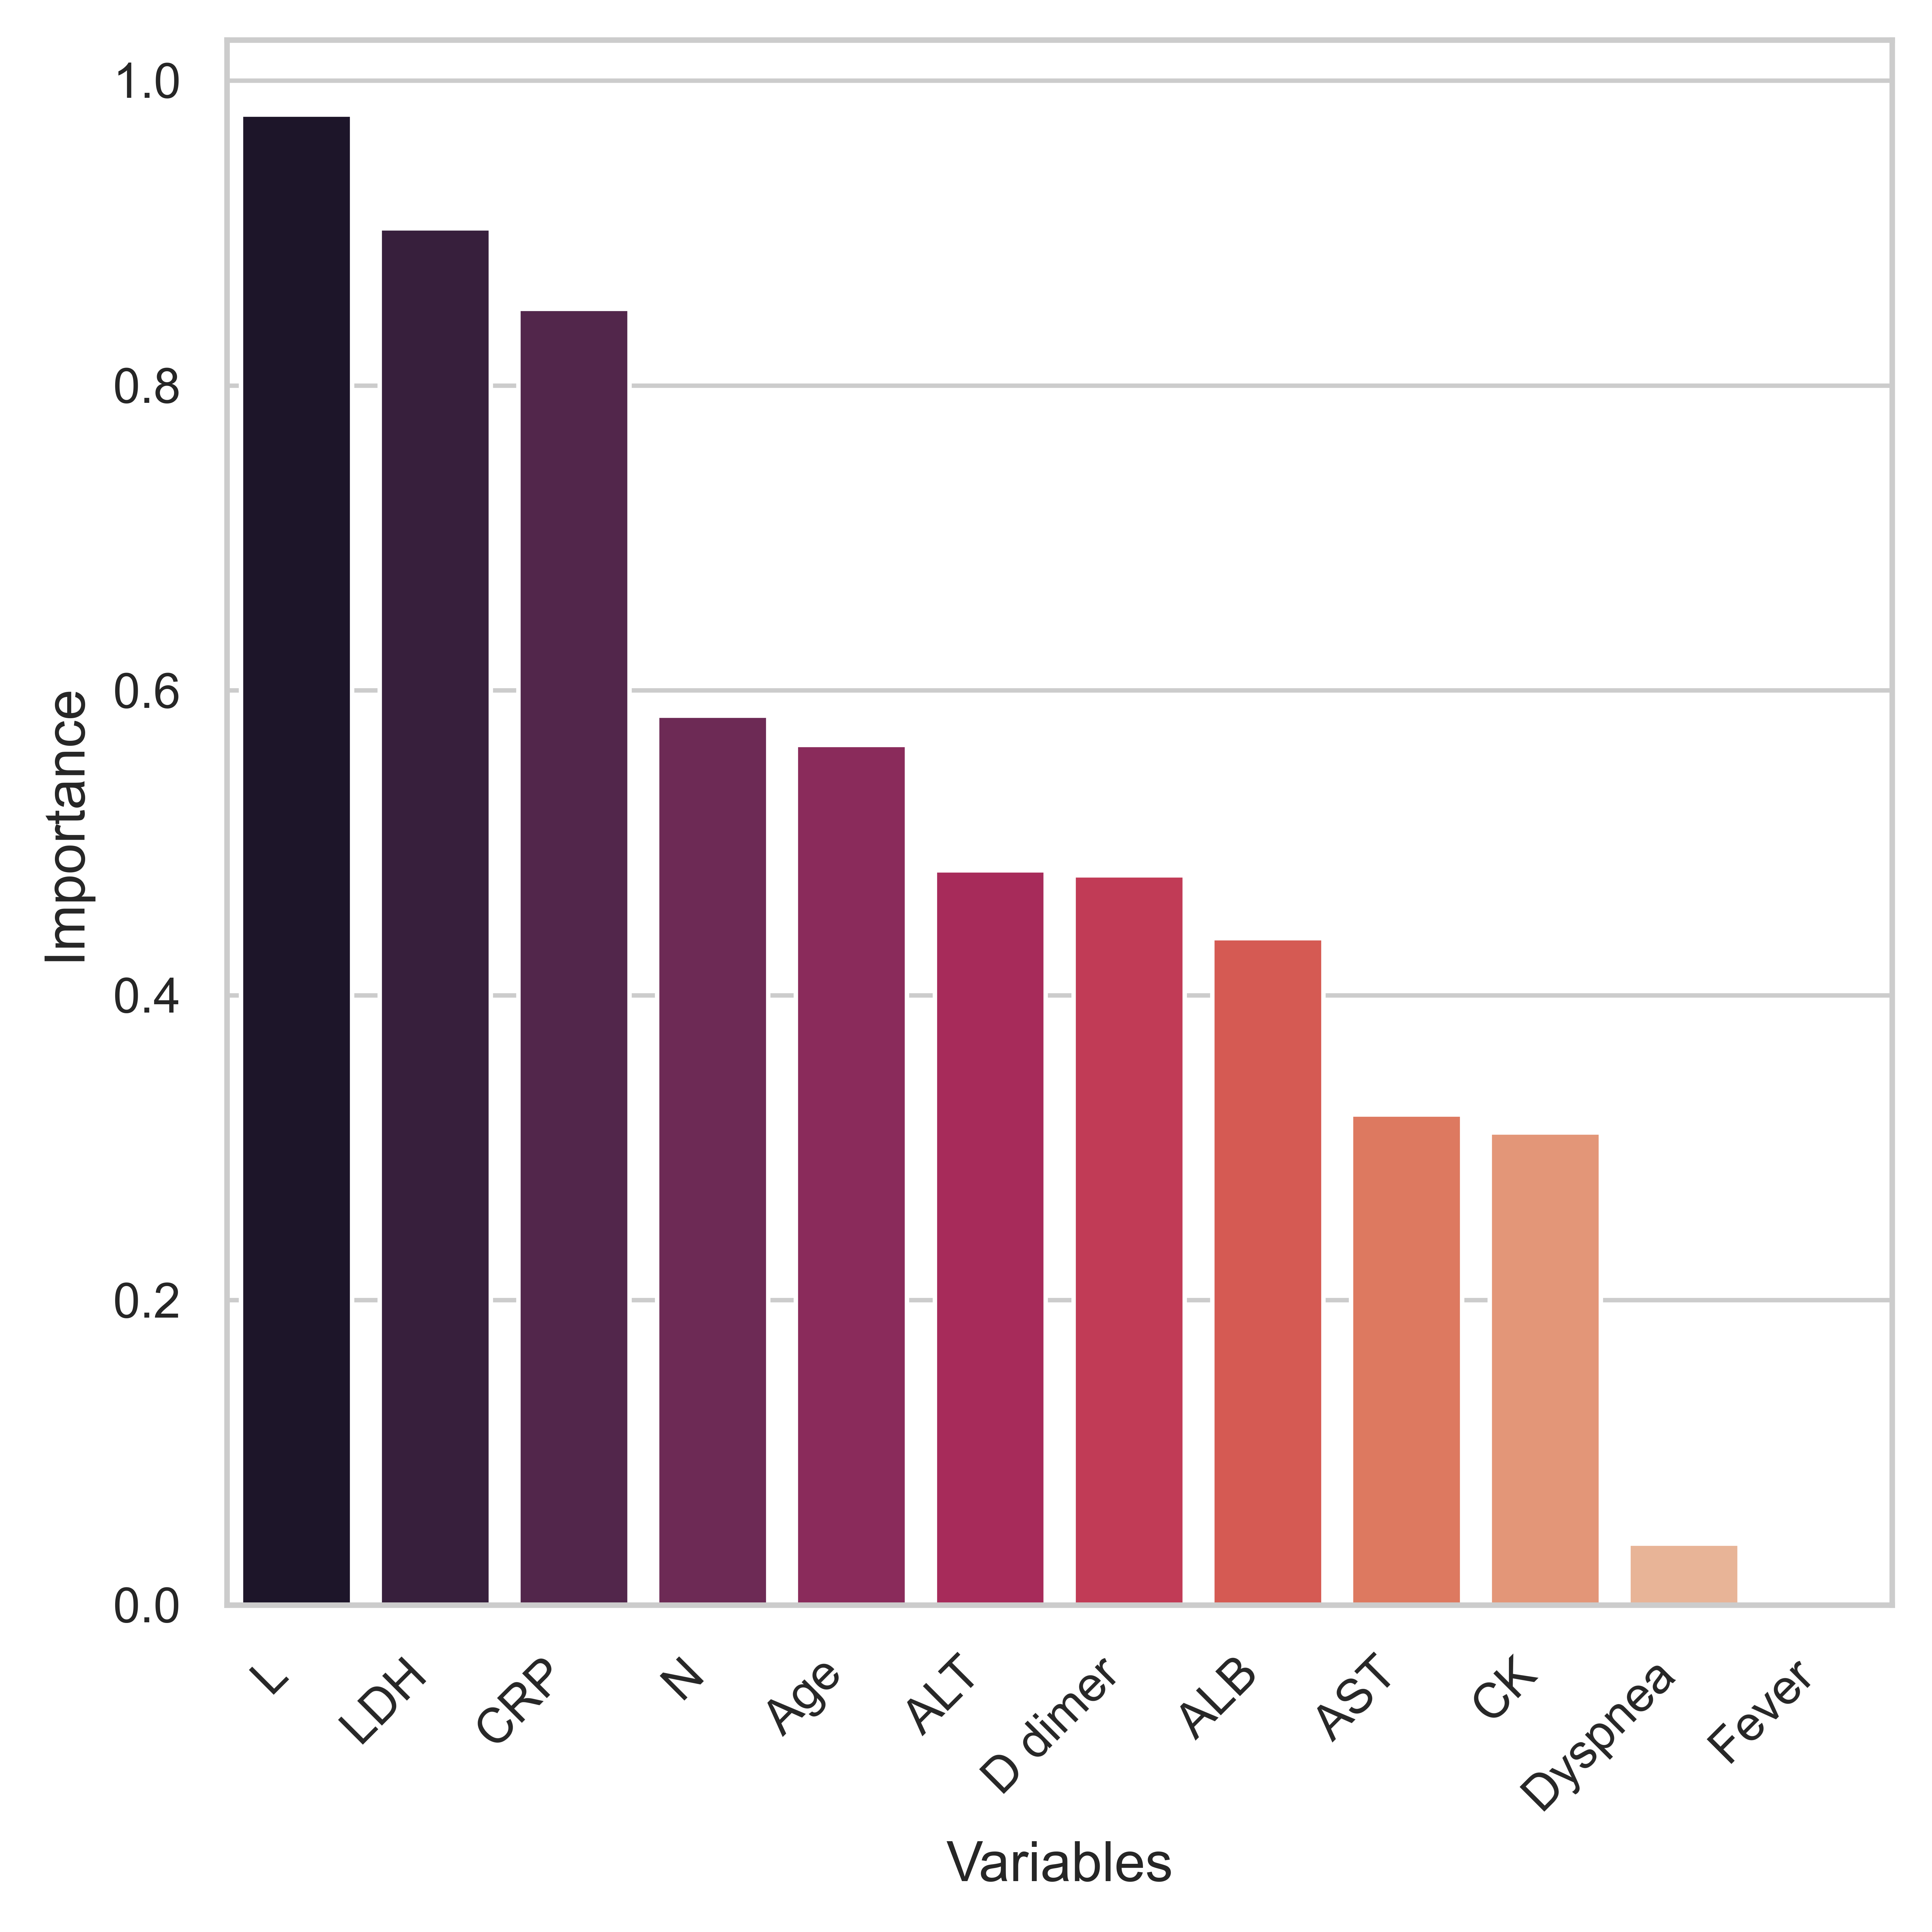

In [9]:
# feature importance
feature_importance = pd.DataFrame()
feature_importance['Variables_name'] = SIGNIFICANT_X
feature_importance["Variables"]=[FEATURE_NAME_MAPPING[i] for i in SIGNIFICANT_X]
feature_importance['Importance'] = 0

for i in range(100):
    classifier = XGBClassifier(**METHODS[1]["hyper_parameters"],random_state=SEED+i)
    t_X_train, _, t_y_train, _ = train_test_split(X_train, y_train, test_size=0.3,
                                                  random_state=SEED + i)
    classifier.fit(t_X_train, t_y_train)
    shap_values = shap.TreeExplainer(classifier).shap_values(t_X_train[SIGNIFICANT_X], y=t_y_train[y], check_additivity=True)
    mean_shap = abs(shap_values).mean(0)
    feature_importance['Importance'] = feature_importance['Importance'] + mean_shap / 100

feature_importance = feature_importance.sort_values(axis=0, ascending=False, by='Importance')
display(feature_importance)
feature_importance.to_csv("./tmp/feature_importance.csv")

importance_plot=sns.barplot(x="Variables", y="Importance",palette="rocket",data=feature_importance)
importance_plot.set_xticklabels(
    importance_plot.get_xticklabels(),
    rotation=45,
    horizontalalignment='right',
)

# plt.show()
plt.tight_layout()
plt.savefig("./paper/Figure_1.png")
# Image(filename="./paper/Figure_1.png")
# plt.clf()
# plt.close()

### Generating

In [10]:
benchmark_result = pd.DataFrame()
reg_X = []
for i in tqdm(range(len(feature_importance))):

    reg_X.append(feature_importance['Variables_name'].values[i])
    if not (len(reg_X) in VAR_NUM):
        continue

    for method in METHODS:
        if method["name"] in COMPARED_METHOD:
            # one_model_result stores the result of a combination of classifier and vars, e.g. 4 variables exgboost performance
            one_model_result = {
                "num": i + 1, # the number of used variables
                "method": method["name"], # the name of classifier
                "external": True, # test set or cross-validation test(validation) set
                "reg_X": json.dumps(reg_X),
            }
            classifier = method["classifier"](**method["hyper_parameters"])
            classifier.fit(X_train[reg_X], y_train)

            # save tmp result for later analysis
            if method["name"]=="XGBoost":
                shap_values = shap.TreeExplainer(classifier).shap_values(X_test[reg_X], y=y_test[y], check_additivity=True)
                with open("./tmp/{}_SHAP_{}.pkl".format(method["name"], len(reg_X)), "wb") as f:
                    pickle.dump([shap_values, X_test[reg_X], reg_X], file=f)

            y_pred_test_external = classifier.predict(X_test[reg_X])
            y_pred_train_external = classifier.predict(X_train[reg_X])

            for k, v in MY_METRICS.items():
                one_model_result[k + "_test"] = v(y_test, y_pred_test_external)
                one_model_result[k + "_train"] = v(y_train, y_pred_train_external)

            # some METHODS dont have auc
            if method["name"] in HAVE_AUC_METHOD:
                y_pred_prob_test_external = classifier.predict_proba(X_test[reg_X])
                y_pred_prob_train_external = classifier.predict_proba(X_train[reg_X])
                # save roc result for later analysis
                with open("./tmp/{}_ROC_{}.pkl".format(method["name"], len(reg_X)), "wb") as f:
                    pickle.dump(roc_curve(y_test, y_pred_prob_test_external[:, 1]), file=f)

                for k, v in {
                    "AUC_macro": partial(roc_auc_score, average="macro"),
                }.items():
                    one_model_result[k + "_test"] = v(y_test, y_pred_prob_test_external[:, 1])
                    one_model_result[k + "_train"] = v(y_train, y_pred_prob_train_external[:, 1])
            benchmark_result = benchmark_result.append(one_model_result, ignore_index=True)

            # CV TEST RESULT
            if RUN_CV_RESULT:
                for j in range(CV_RESULT_REPEAT):
                    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=j * 9)
                    for train_index, test_index in kfold.split(X_train[reg_X], y_train[[y]]):

                        t_X_train, t_X_test = X_train[reg_X].iloc[train_index], X_train[reg_X].iloc[test_index]
                        t_y_train, t_y_test = y_train[[y]].iloc[train_index], y_train[[y]].iloc[test_index]

                        classifier = method["classifier"](**method["hyper_parameters"])
                        classifier.fit(t_X_train, t_y_train)
                        t_y_pred_test_CV = classifier.predict(t_X_test)
                        t_y_pred_train_CV = classifier.predict(t_X_train)

                        one_model_result = {"num": i + 1, "method": method["name"], "external": False, "reg_X": json.dumps(reg_X)}
                        for k, v in MY_METRICS.items():
                            one_model_result[k + "_test"] = v(t_y_test, t_y_pred_test_CV)
                            one_model_result[k + "_train"] = v(t_y_train, t_y_pred_train_CV)
                        if method["name"] in HAVE_AUC_METHOD:
                            t_y_pred_prob_test_CV = classifier.predict_proba(t_X_test)
                            t_y_pred_prob_train_CV = classifier.predict_proba(t_X_train)

                            for k, v in {
                                "AUC_macro": partial(roc_auc_score, average="macro"),
                            }.items():
                                one_model_result[k + "_test"] = v(t_y_test, t_y_pred_prob_test_CV[:, 1])
                                one_model_result[k + "_train"] = v(t_y_train, t_y_pred_prob_train_CV[:, 1])

                        benchmark_result = benchmark_result.append(one_model_result, ignore_index=True)

# too large to display
# display(benchmark_result)
benchmark_result.to_csv("./paper/benchmark.csv")
pivot_benchmark_result=benchmark_result.pivot_table(
    values=
    [
        "AUC_macro_test",
        "F1_weighted_test",
        "Accuracy_test",
        "Sensitivity_test",
        "Specifity_test",
    ],
    aggfunc=[np.mean, np.std],
    columns=["external", "method"],
    index=["num"])
display(pivot_benchmark_result)
pivot_benchmark_result.to_csv("./paper/benchmark_pivot.csv")

mean                                              \
         AUC_macro_test                                               
external            0.0                                               
method    Decision Tree       LDA  Logistic Random Forest   XGBoost   
num                                                                   
1.0            0.741298  0.816424  0.816424      0.670487  0.697616   
2.0            0.780867  0.844899  0.855710      0.804442  0.807476   
3.0            0.777161  0.871973  0.881870      0.864391  0.844630   
4.0            0.778041  0.877870  0.888812      0.858645  0.849842   
5.0            0.761238  0.878964  0.887220      0.857593  0.853709   
6.0            0.760460  0.879592  0.892502      0.855050  0.864413   
7.0            0.758470  0.886575  0.899415      0.867779  0.862993   
8.0            0.755128  0.877570  0.891147      0.870431  0.850418   
9.0            0.753802  0.872688  0.889754      0.860559  0.846959   
10.0           0.752691  0.870988  0.884014      0.862122  0.841169   
11.0           0.752580  0.869737  0.881109      0.858680  0.842430   
12.0           0.752580  0.866773  0.881196      0.863170  0.841184   

                                                                    ...  \
                                                                    ...   
external           1.0                                              ...   
method   Decision Tree       LDA  Logistic Random Forest   XGBoost  ...   
num                                                                 ...   
1.0           0.633876  0.798817  0.798817      0.835799  0.815828  ...   
2.0           0.793639  0.871302  0.871302      0.784024  0.803254  ...   
3.0           0.679734  0.887574  0.884615      0.826183  0.813609  ...   
4.0           0.679734  0.875740  0.878698      0.861686  0.856509  ...   
5.0           0.679734  0.883136  0.887574      0.830621  0.862426  ...   
6.0           0.679734  0.892012  0.883136      0.861686  0.883136  ...   
7.0           0.676036  0.897929  0.894970      0.877959  0.917160  ...   
8.0           0.676036  0.899408  0.899408      0.916420  0.906805  ...   
9.0           0.676036  0.896450  0.900888      0.920118  0.924556  ...   
10.0          0.676036  0.893491  0.893491      0.910503  0.923077  ...   
11.0          0.676036  0.930473  0.914201      0.909763  0.936391  ...   
12.0          0.676036  0.928994  0.917160      0.925296  0.943787  ...   

                      std                                                   \
         Sensitivity_test                                   Specifity_test   
external              0.0                                              0.0   
method           Logistic Random Forest       SVM   XGBoost  Decision Tree   
num                                                                          
1.0              0.143285      0.180531  0.162010  0.184449       0.049530   
2.0              0.180422      0.192438  0.186382  0.154247       0.056015   
3.0              0.209009      0.189793  0.180104  0.140404       0.058429   
4.0              0.200018      0.188828  0.193191  0.142406       0.052622   
5.0              0.197774      0.194798  0.201722  0.162937       0.054421   
6.0              0.198263      0.206368  0.207200  0.158397       0.054925   
7.0              0.192866      0.188847  0.202962  0.160286       0.054934   
8.0              0.198109      0.198362  0.191204  0.158815       0.054011   
9.0              0.193181      0.185814  0.186055  0.160119       0.054664   
10.0             0.199012      0.190199  0.180372  0.152670       0.054783   
11.0             0.186190      0.187418  0.187054  0.158601       0.054783   
12.0             0.187437      0.176099  0.181856  0.155047       0.054783   

                                                                
                                                                
external                                                        
method       

In [11]:
for i in [4,12]:
    table=benchmark_result[(benchmark_result.external==1) & (benchmark_result.num==i)].pivot_table(
        values=
        [
            "AUC_macro_test",
            "F1_weighted_test",
            "Accuracy_test",
            "Sensitivity_test",
            "Specifity_test",
        ],
        aggfunc=[np.mean],
        index=["method"])["mean"].T
    table.to_csv("./paper/Table_{}.csv".format({4:4,12:3}[i]))
    display(table)
# slightly different(<1%) with paper because of randomness, but the ranking among methods as well as analysis remain the same

method            Decision Tree       LDA  Logistic  Random Forest       SVM  \
AUC_macro_test         0.679734  0.875740  0.878698       0.861686       NaN   
Accuracy_test          0.800000  0.830769  0.815385       0.861538  0.830769   
F1_weighted_test       0.769464  0.814504  0.802020       0.854449  0.814504   
Sensitivity_test       0.230769  0.384615  0.384615       0.538462  0.384615   
Specifity_test         0.942308  0.942308  0.923077       0.942308  0.942308   

method             XGBoost  
AUC_macro_test    0.856509  
Accuracy_test     0.861538  
F1_weighted_test  0.869208  
Sensitivity_test  0.846154  
Specifity_test    0.865385

method            Decision Tree       LDA  Logistic  Random Forest       SVM  \
AUC_macro_test         0.676036  0.928994  0.917160       0.925296       NaN   
Accuracy_test          0.800000  0.892308  0.861538       0.861538  0.861538   
F1_weighted_test       0.769464  0.890667  0.854449       0.854449  0.848231   
Sensitivity_test       0.230769  0.692308  0.538462       0.538462  0.461538   
Specifity_test         0.942308  0.942308  0.942308       0.942308  0.961538   

method             XGBoost  
AUC_macro_test    0.943787  
Accuracy_test     0.892308  
F1_weighted_test  0.896279  
Sensitivity_test  0.846154  
Specifity_test    0.903846

### Analysis for simple model
the simple model reders to a model which use less variables and achieve comparable performance.

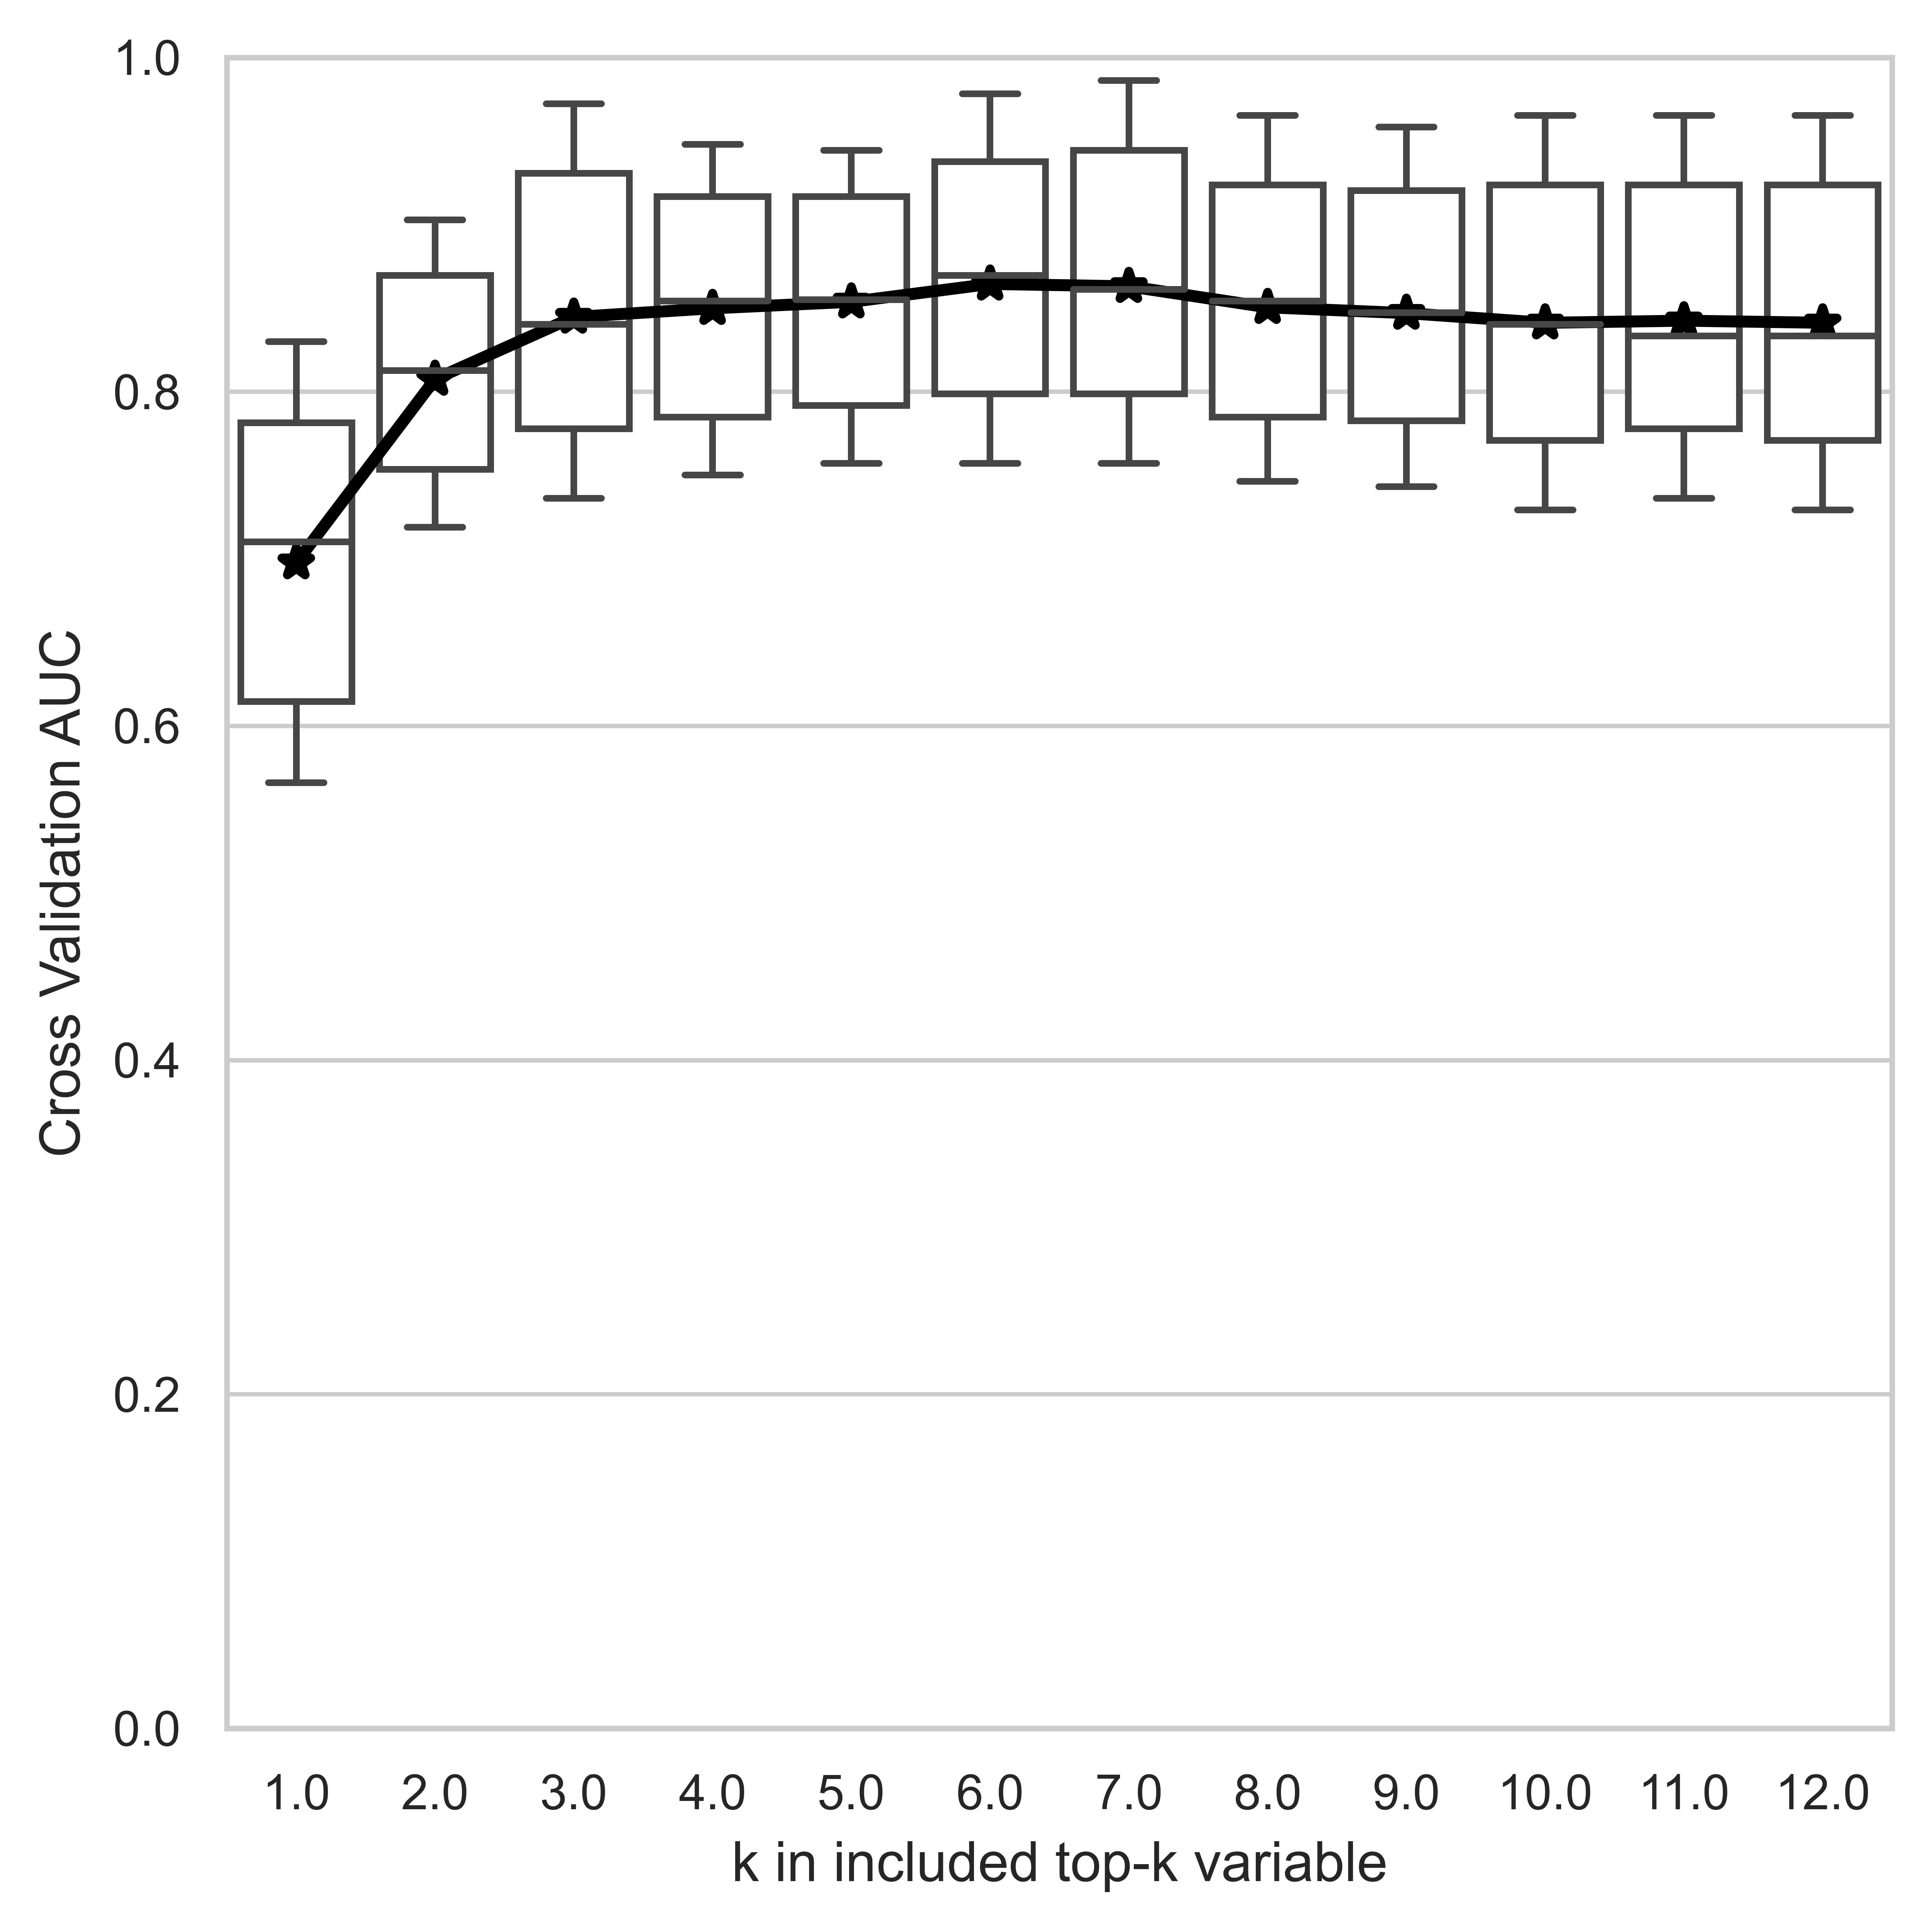

In [12]:
benchmark_result_plot_cv_auc_vars_num=benchmark_result[benchmark_result.method=="XGBoost"][benchmark_result.external==0]
pivot=benchmark_result_plot_cv_auc_vars_num.pivot_table(
            values=[
                "AUC_macro_test",
                "AUC_macro_train",
            ],
            aggfunc=[np.mean, np.std,q25,q75],columns=["num"])
curve,ub,lb=[],[],[]
for i in range(1,13):
    curve.append(pivot["mean", i]["AUC_macro_test"])
    ub.append(pivot["q25", i]["AUC_macro_test"])
    lb.append(pivot["q75", i]["AUC_macro_test"])
fig, ax = plt.subplots()
plt.ylim(0, 1)
plt.xlim(0, 13)
plt.xticks([i for i in range(1,13)])

benchmark_result_plot_cv_auc_vars_num["Cross Validation AUC"]=benchmark_result_plot_cv_auc_vars_num["AUC_macro_test"]
benchmark_result_plot_cv_auc_vars_num["k in included top-k variable"]=benchmark_result_plot_cv_auc_vars_num["num"]
sns.pointplot(x="k in included top-k variable", y="Cross Validation AUC", data=benchmark_result_plot_cv_auc_vars_num,estimator=np.mean,ci="sd",color="black",markers="*",errwidth=0)
t=sns.boxplot(x="k in included top-k variable", y="Cross Validation AUC",data=benchmark_result_plot_cv_auc_vars_num,whis=0.3,fliersize=0)
for i in t.artists:
    i.set_facecolor('white')
# plt.show()
plt.tight_layout()
plt.savefig("./paper/Figure_2.png")
# Image(filename="./paper/Figure_2.png")
# plt.clf()
# plt.close()

### ROC Curve of 4,12 variables models

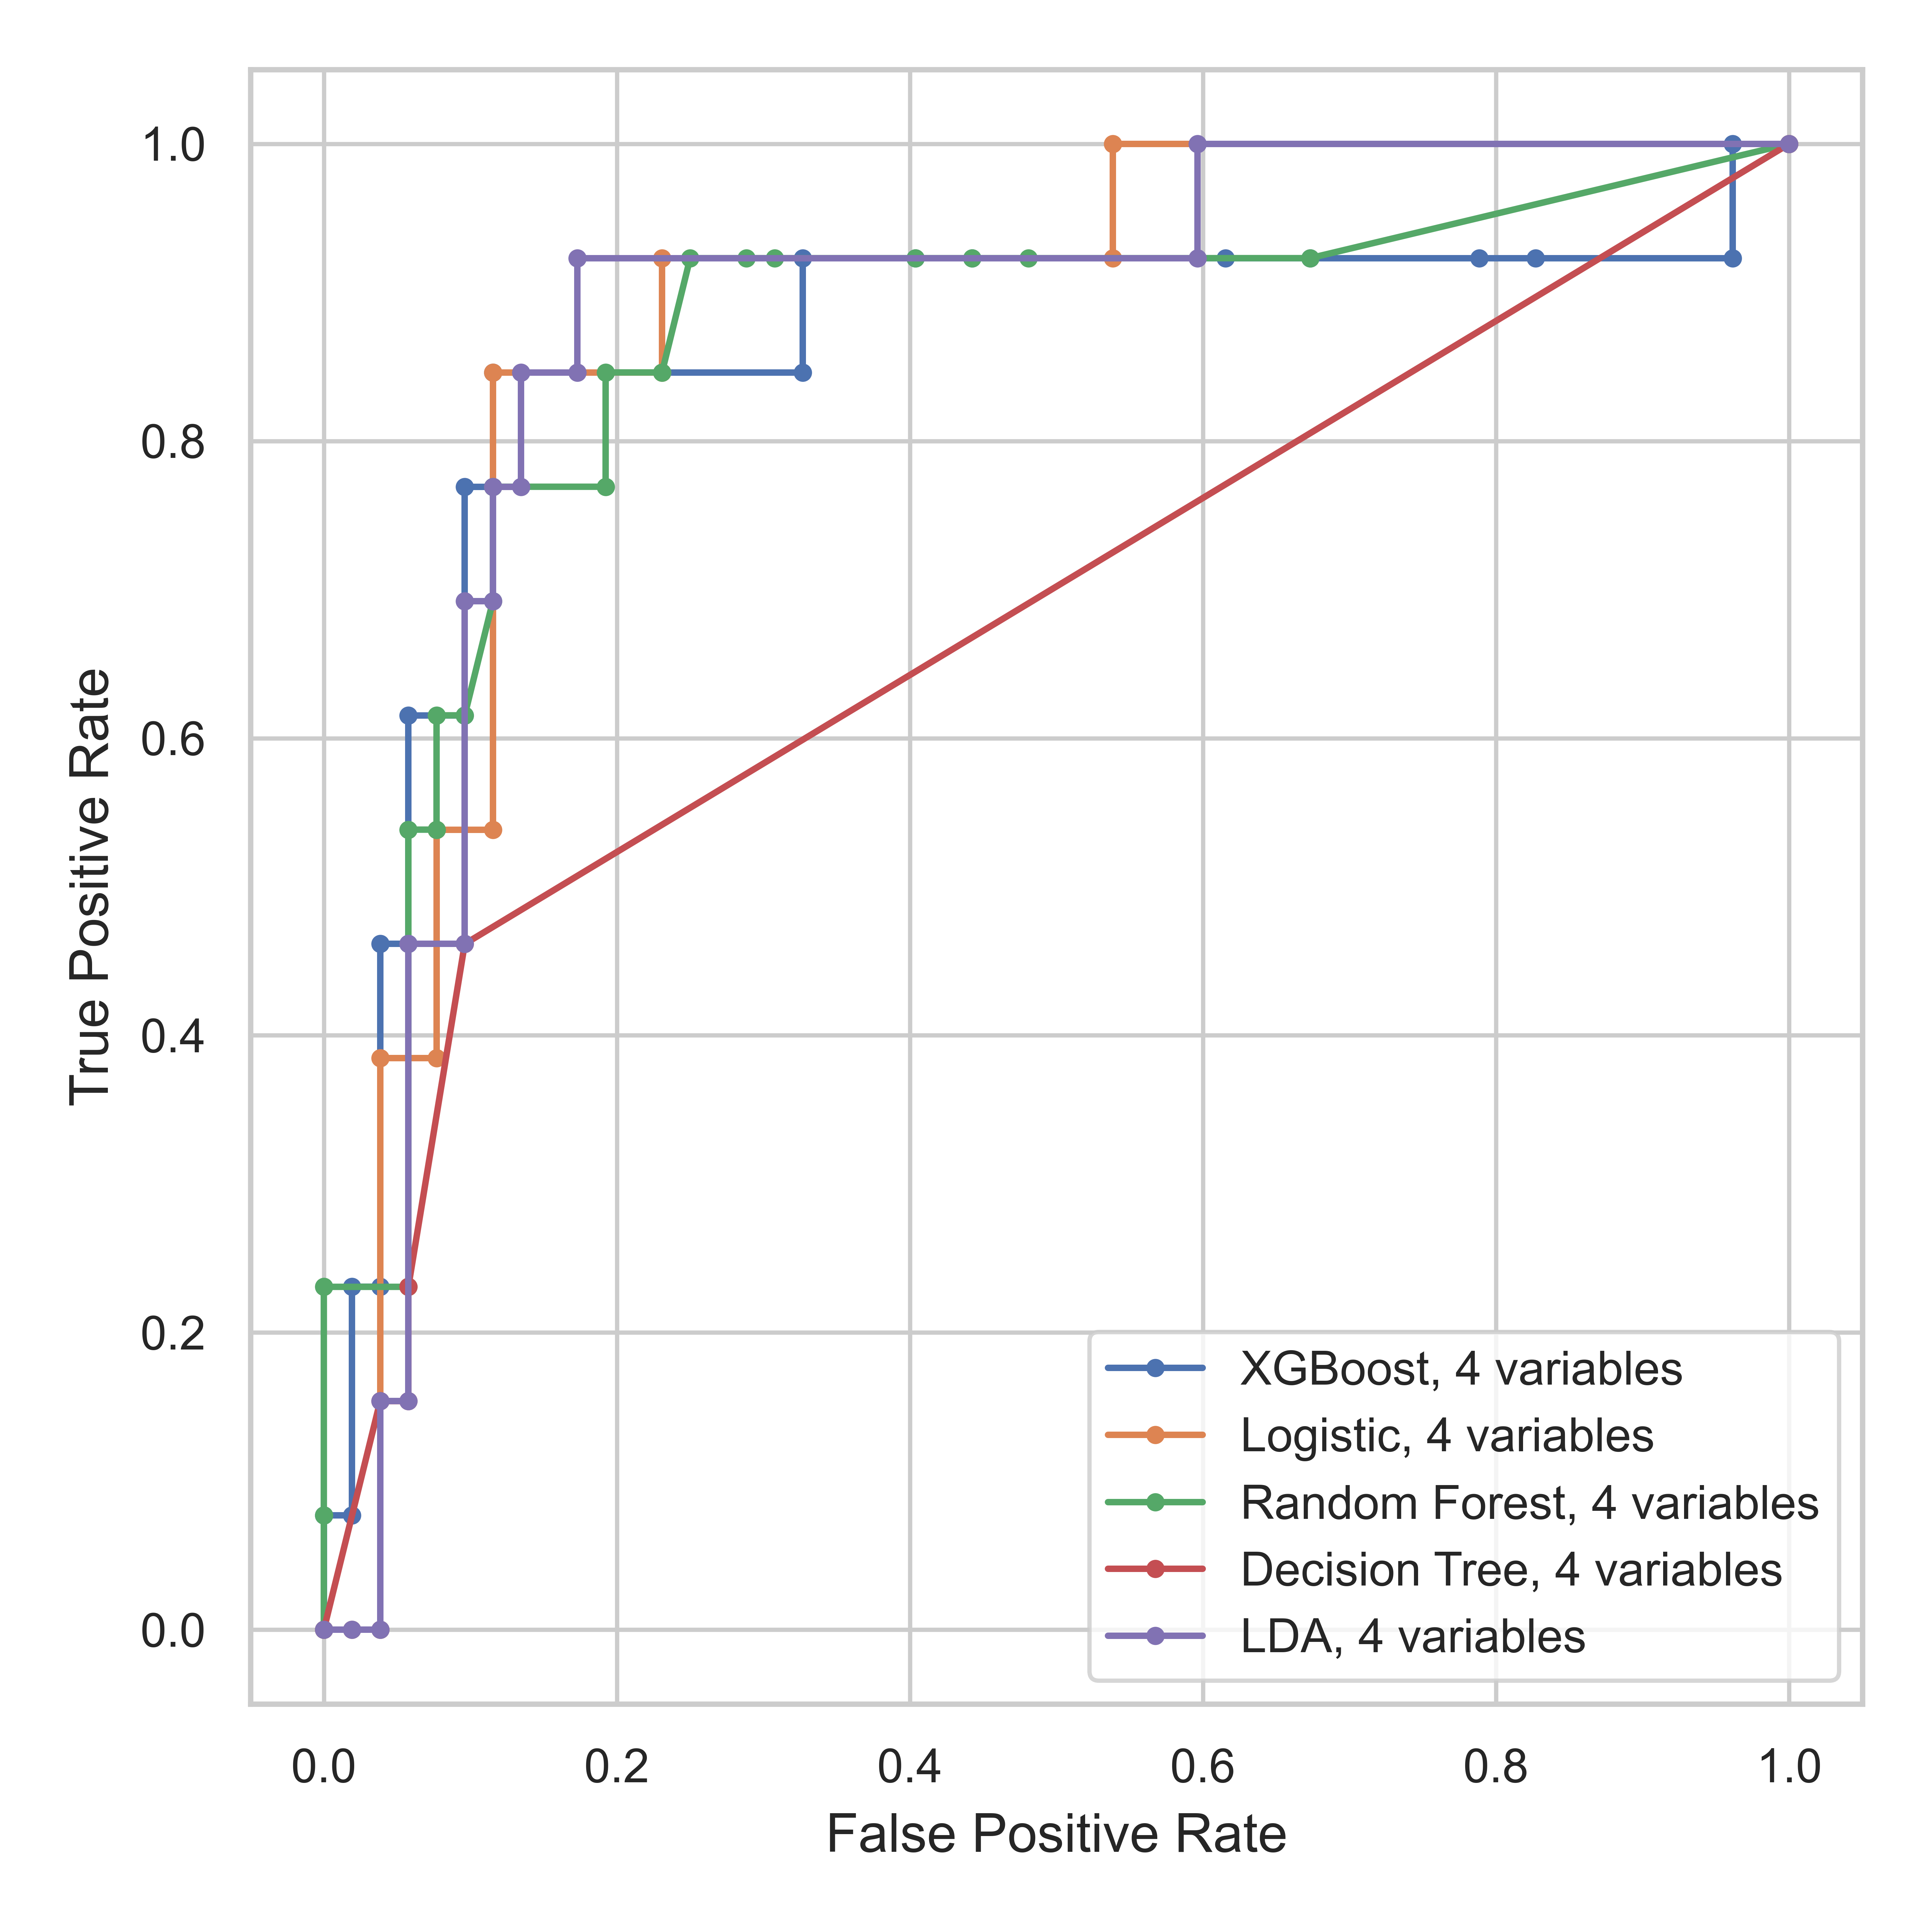

In [13]:
for j in [4,12]: # can be more, but not necessary
    # plt.subplot("12{}".format({4:1,12:2}[j]))
    fpr, tpr = [], []
    name = []
    for method in METHODS:
        if method["name"] in \
                [
                    "XGBoost",
                    "Logistic",
                    "Random Forest",
                    "Decision Tree",
                    "LDA"
                ]:
            with open("./tmp/{}_ROC_{}.pkl".format(method["name"], j), "rb") as f:
                t_fpr, t_tpr, thresholds = pickle.load(f)
            fpr.append(t_fpr)
            tpr.append(t_tpr)
            name.append({
                            "XGBoost": "XGBoost",
                            "Logistic": "Logistic",
                            "Random Forest": "Random Forest",
                            "Decision Tree": "Decision Tree",
                            "LDA": "LDA"
                        }[method["name"]] + ", " + str(
                j) + " variables")

    for i in range(len(fpr)):
        plt.plot(fpr[i], tpr[i], marker='.', label=name[i], alpha=1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    # plt.show()
    plt.tight_layout()
    plt.savefig("./paper/Figure_3_{}.png".format({12:"A",4:"B"}[j]))
    plt.clf()
    plt.close()
Image(filename="./paper/Figure_3_A.png")
Image(filename="./paper/Figure_3_B.png")
    # plt.clf()
    # plt.close()
    # axis labels

### Explain the 4 variable XGboost

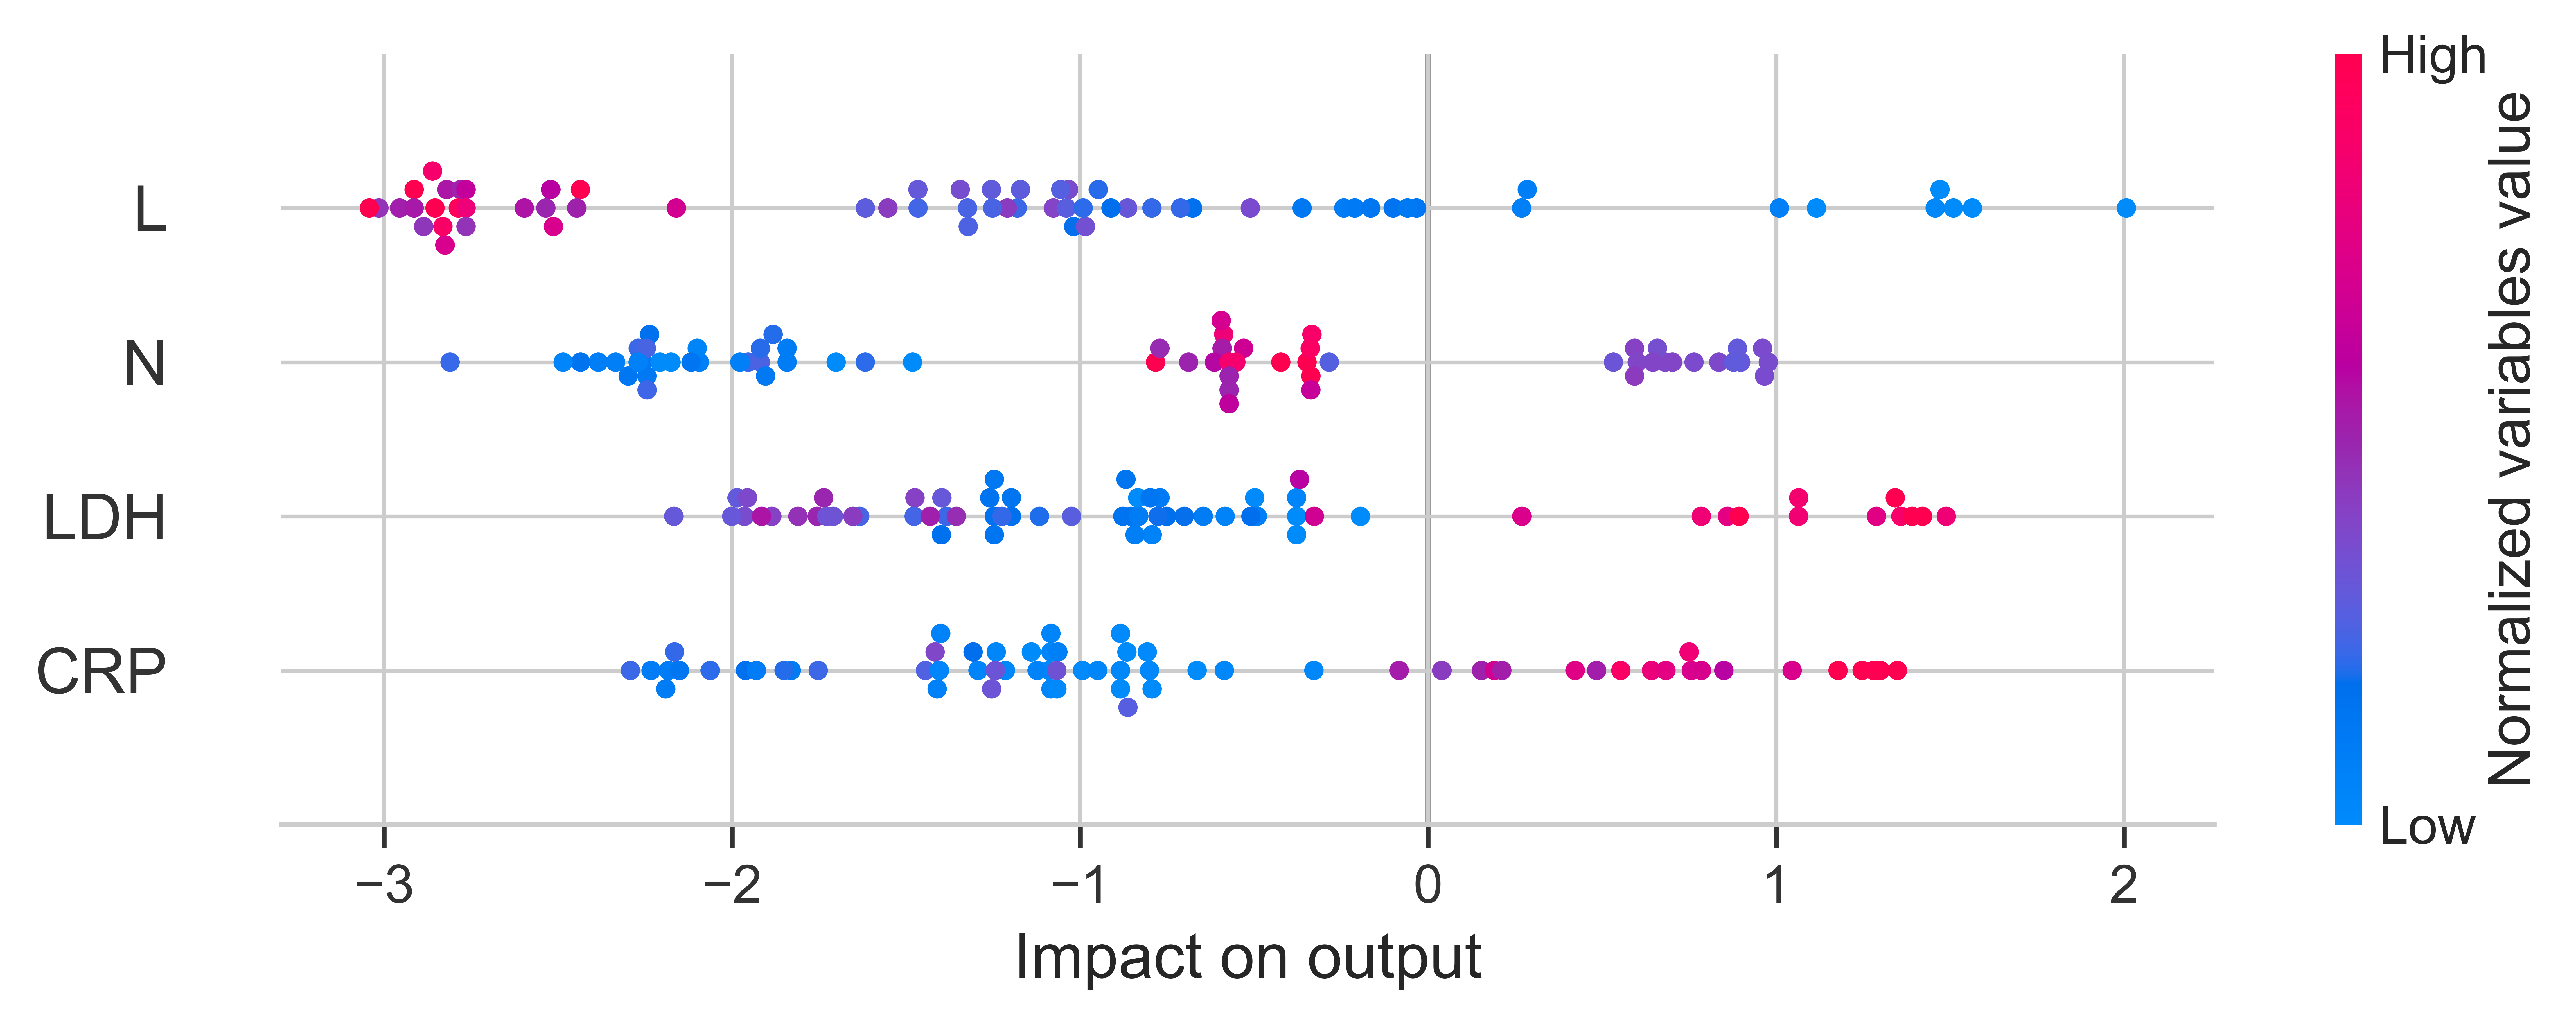

In [14]:
plt.xlabel("impact on output")
with open("./tmp/{}_SHAP_{}.pkl".format("XGBoost", 4), "rb") as f:
    shap_values, X_test, reg_X= pickle.load(f)
reg_X_name=[FEATURE_NAME_MAPPING[i] for i in reg_X]
shap.summary_plot(shap_values, X_test[reg_X],
                  show=False,
                  feature_names=reg_X_name,
                  color_bar_label="Normalized variables value"
                  )
#
plt.xlabel("Impact on output")
# plt.show()
plt.tight_layout()
plt.savefig("./paper/Supplementary_Figure_3.png")
# Image(filename="./paper/Supplementary_Figure_3.png")

# plt.clf()
# plt.close()

### Comparision with similar method
comparing the variable selected in this paper *Yan, L., et al., An interpretable mortality prediction model for COVID-19 patients. Nature Machine Intelligence, 2020. 2(5): p. 283-288.*

In [15]:
reg_X = ["Laboratory_test_L", 'Laboratory_test_LDH_(U/L)', 'Laboratory_test_CRP_(mg/L)']

method=METHODS[5]
Supplementary_Table_2 = {}
classifier = method["classifier"](**method["hyper_parameters"])
classifier.fit(X_train[reg_X], y_train)

# plot trees
img = xgb.to_graphviz(classifier)
img.render(filename='./tmp/single-tree.dot')
display(IFrame('./tmp/single-tree.dot.pdf',width=1000, height=400))

y_pred_test_external = classifier.predict(X_test[reg_X])
y_pred_prob_test_external = classifier.predict_proba(X_test[reg_X])

for k, v in MY_METRICS.items():
    Supplementary_Table_2[k + "_test"] = v(y_test, y_pred_test_external)
for k, v in {
            "AUC_macro": partial(roc_auc_score, average="macro"),
        }.items():
    Supplementary_Table_2[k + "_test"] = v(y_test, y_pred_prob_test_external[:, 1])
pd.DataFrame().append(Supplementary_Table_2,ignore_index=True)[["AUC_macro_test",
     "F1_weighted_test",
     "Accuracy_test",
     "Sensitivity_test",
     "Specifity_test",
     ]].to_csv("./paper/Supplementary_Table_2.csv")

## The progression case
The progression case refers to the case transform from non-sever to sever.

In [16]:
SELECTED_X = [feature_importance['Variables_name'].values[i] for i in range(4)]
dataset_tranmit_removing_missing_value=dataset[dataset.non_severe_to_severe == 1][[*SELECTED_X, y]].dropna()
dataset_tranmit_removing_missing_value.to_csv("./tmp/dataset_remove_missing_value_thresh_350_non_severe_to_severe.csv")
for i in VARS_REMOVED_MISSING_SIGNIFICANT["num"]:
    if i in dataset_tranmit_removing_missing_value.columns:
        dataset_tranmit_removing_missing_value[i] = (dataset_tranmit_removing_missing_value[i] - dataset_non_tranmit_removing_missing_value[i].mean()) / dataset_non_tranmit_removing_missing_value[i].std()

In [17]:
non_severe_to_severe_benchmark_result = pd.DataFrame()
reg_X = []
for i in tqdm(range(len(feature_importance))):

    reg_X.append(feature_importance['Variables_name'].values[i])
    if not (len(reg_X) in [4]):
        continue

    for method in METHODS:
        if method["name"] in COMPARED_METHOD:
            # one_model_result stores the result of a combination of classifier and vars, e.g. 4 variables exgboost performance
            one_model_result = {
                "num": i + 1, # the number of used variables
                "method": method["name"], # the name of classifier
                "external": True, # test set or cross-validation test(validation) set
                "reg_X": json.dumps(reg_X),
            }
            classifier = method["classifier"](**method["hyper_parameters"])
            classifier.fit(X_train[reg_X], y_train)

            y_pred_non_severe_to_severe = classifier.predict(dataset_tranmit_removing_missing_value[reg_X])
            one_model_result["non_severe_to_severe_accuracy"] = y_pred_non_severe_to_severe.mean()

            non_severe_to_severe_benchmark_result = non_severe_to_severe_benchmark_result.append(one_model_result, ignore_index=True)


# too large to display
# display(non_severe_to_severe_benchmark_result)
non_severe_to_severe_benchmark_result.to_csv("./paper/Table_5.csv")
display(non_severe_to_severe_benchmark_result)


external         method  non_severe_to_severe_accuracy  num  \
0       1.0        XGBoost                       1.000000  4.0   
1       1.0       Logistic                       1.000000  4.0   
2       1.0  Random Forest                       0.974359  4.0   
3       1.0            SVM                       1.000000  4.0   
4       1.0  Decision Tree                       0.974359  4.0   
5       1.0            LDA                       1.000000  4.0   

                                               reg_X  
0  ["Laboratory_test_L", "Laboratory_test_LDH_(U/...  
1  ["Laboratory_test_L", "Laboratory_test_LDH_(U/...  
2  ["Laboratory_test_L", "Laboratory_test_LDH_(U/...  
3  ["Laboratory_test_L", "Laboratory_test_LDH_(U/...  
4  ["Laboratory_test_L", "Laboratory_test_LDH_(U/...  
5  ["Laboratory_test_L", "Laboratory_test_LDH_(U/...

### t-SNE Visualization

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>


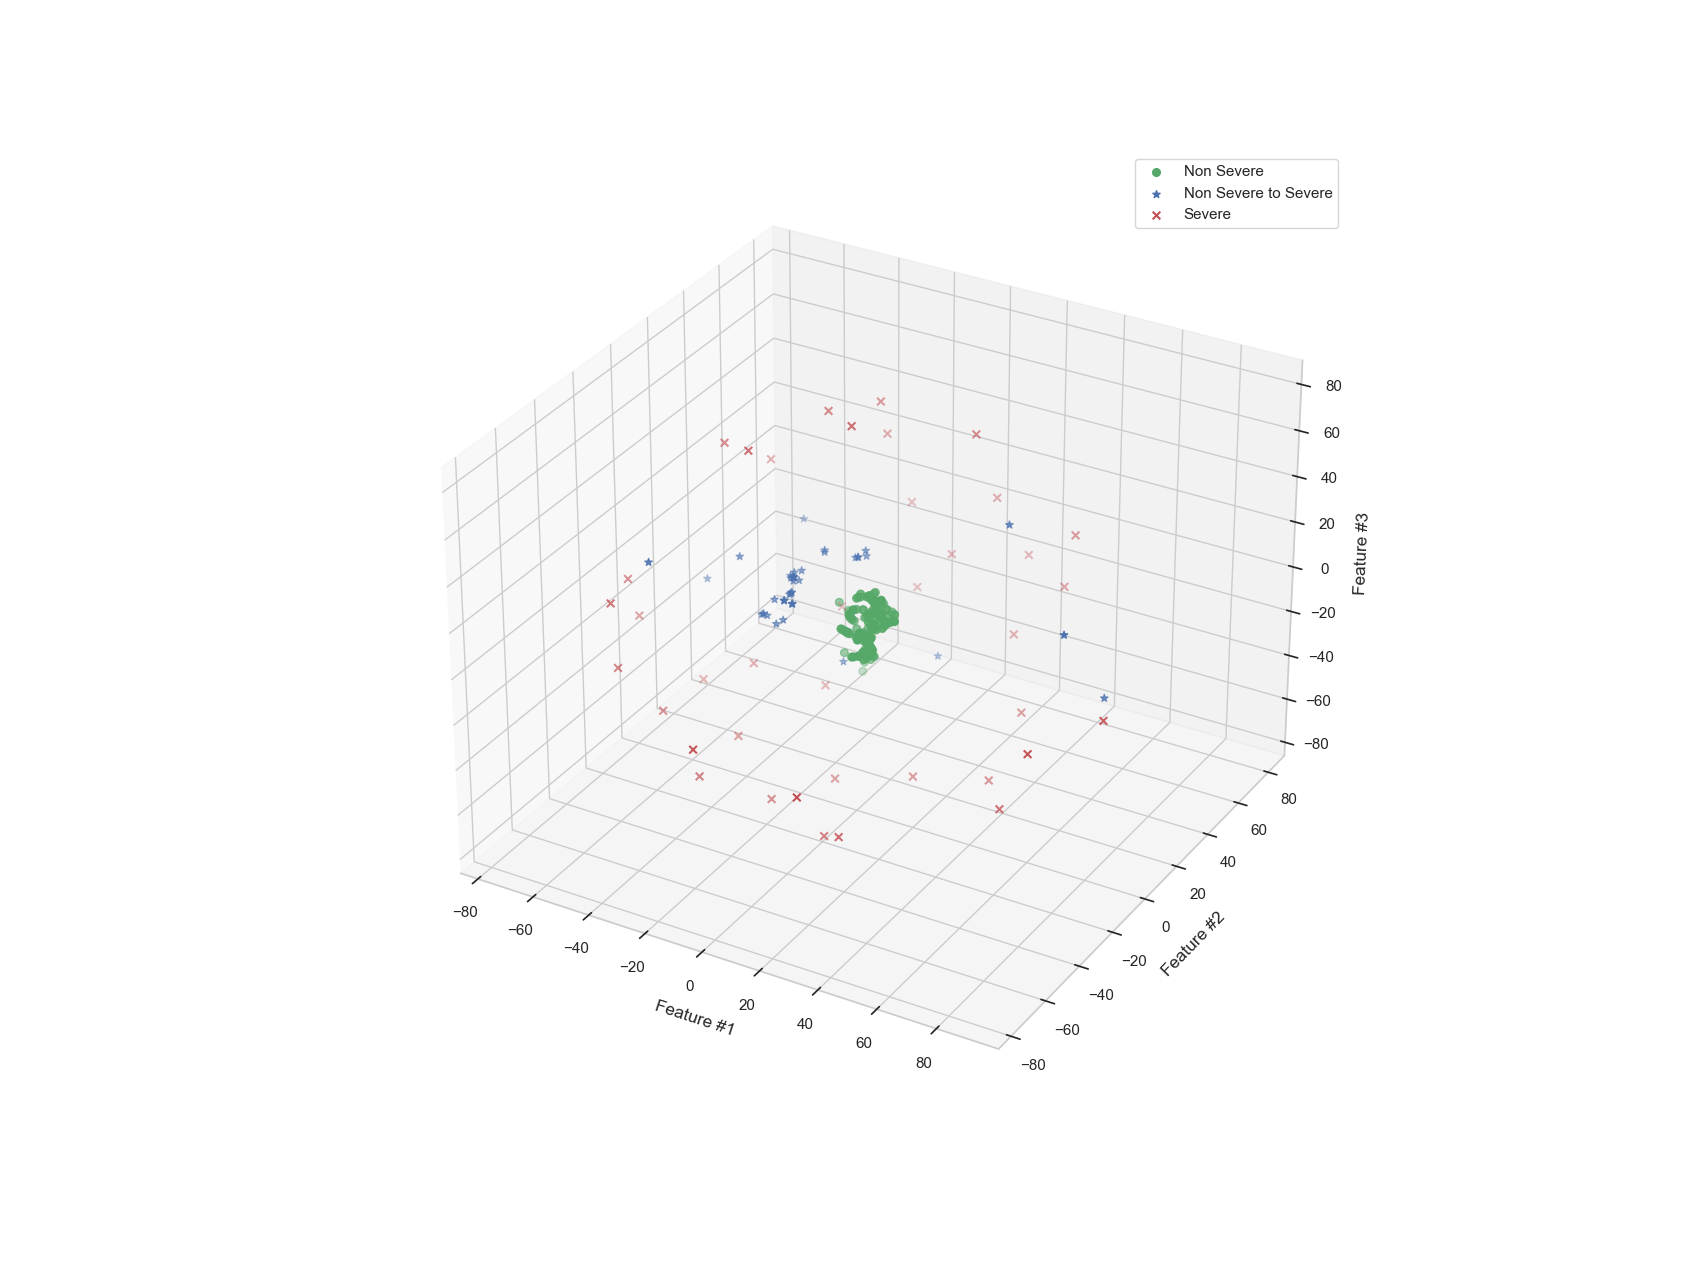

In [18]:
%matplotlib notebook
%pylab

def run_tsne():
    # to run this function, please use tensorboard
    dataset=pd.read_csv("./dataset.csv",index_col=0)

    # non_sever = pd.read_excel("./tmp/non_Severe.xlsx",index_col=0)
    # sever = pd.read_excel("./tmp/Severe.xlsx", index_col=0)
    # trans = pd.read_excel("./tmp/trans.xlsx", index_col=0)
    non_sever=dataset[dataset.Degree_Severe==0][SELECTED_X]
    sever=dataset[dataset.Degree_Severe==1][SELECTED_X]
    trans=dataset[dataset.non_severe_to_severe==0][SELECTED_X]
    non_sever["label"] = 1
    sever["label"] = 3
    trans["label"] = 2
    non_sever = non_sever.values
    sever = sever.values
    trans = trans.values
    data = np.concatenate([non_sever, sever, trans], axis=0)
    writer = tensorboardX.SummaryWriter(comment="tsne")
    writer.add_embedding(data[:, :4], data[:, 4])
    writer.close()
def plot_tsne_pc():

    with open("./tsne_point_cloud.json","r") as f:
        t=json.load(f)

    pc=[(k["tsne-0"],k["tsne-1"],k["tsne-2"],0) for k in t[0]["projections"]]
    lb=[]
    for idx,k in enumerate(t[0]["projections"]):
        if idx<171:
            lb.append("Non Severe")
        elif idx<214:
            lb.append("Severe")
        elif idx<253:
            lb.append("Non Severe to Severe")
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    pc=np.array(pc)
    ax.scatter(pc[:171,0], pc[:171,1], pc[:171,2],c="g",marker="o",)
    ax.scatter(pc[171:214,0], pc[171:214,1], pc[171:214,2],c="b",marker="*")
    ax.scatter(pc[214:253,0], pc[214:253,1], pc[214:253,2],c="r",marker="x")
    ax.set_xlabel('Feature #1')
    ax.set_ylabel('Feature #2')
    ax.set_zlabel('Feature #3')
    ax.legend(["Non Severe","Non Severe to Severe","Severe"])
    plt.show()
# run_tsne()
plot_tsne_pc()

### Export 4,12 vars XGBoost


In [19]:
# 4 var xgboost

SELECTED_X_4 = [feature_importance['Variables_name'].values[i] for i in range(4)]
dataset_deploy_4=dataset[[*SELECTED_X_4,y]].dropna()
mean_var_4=[]
for i in SELECTED_X_4:
    mean_var_4.append([dataset_deploy_4[i].mean(),dataset_deploy_4[i].std()])
    dataset_deploy_4[i]=(dataset_deploy_4[i]-dataset_deploy_4[i].mean())/dataset_deploy_4[i].std()

classifier_4 = METHODS[0]["classifier"](**METHODS[0]["hyper_parameters"])
classifier_4.fit(dataset_deploy_4[SELECTED_X_4], dataset_deploy_4[y])

with open("./deploy/model_4.pkl","wb") as f:
    pickle.dump(classifier_4,f)

with open("./deploy/mean_var_4.pkl","wb") as f:
    pickle.dump(mean_var_4,f)

# # 12 var xgboost
# SELECTED_X_12 = [feature_importance['Variables_name'].values[i] for i in range(12)]
# classifier_12 = METHODS[0]["classifier"](**METHODS[0]["hyper_parameters"])
# classifier_12.fit(dataset[SELECTED_X_12], dataset[y])
# with open("./deploy/model_12.pkl","wb") as f:
#     pickle.dump(classifier_12,f)